## BMC

Loaded 693 BTOR2 benchmarks
Loaded 693 C benchmarks
Successfully matched 186 benchmarks


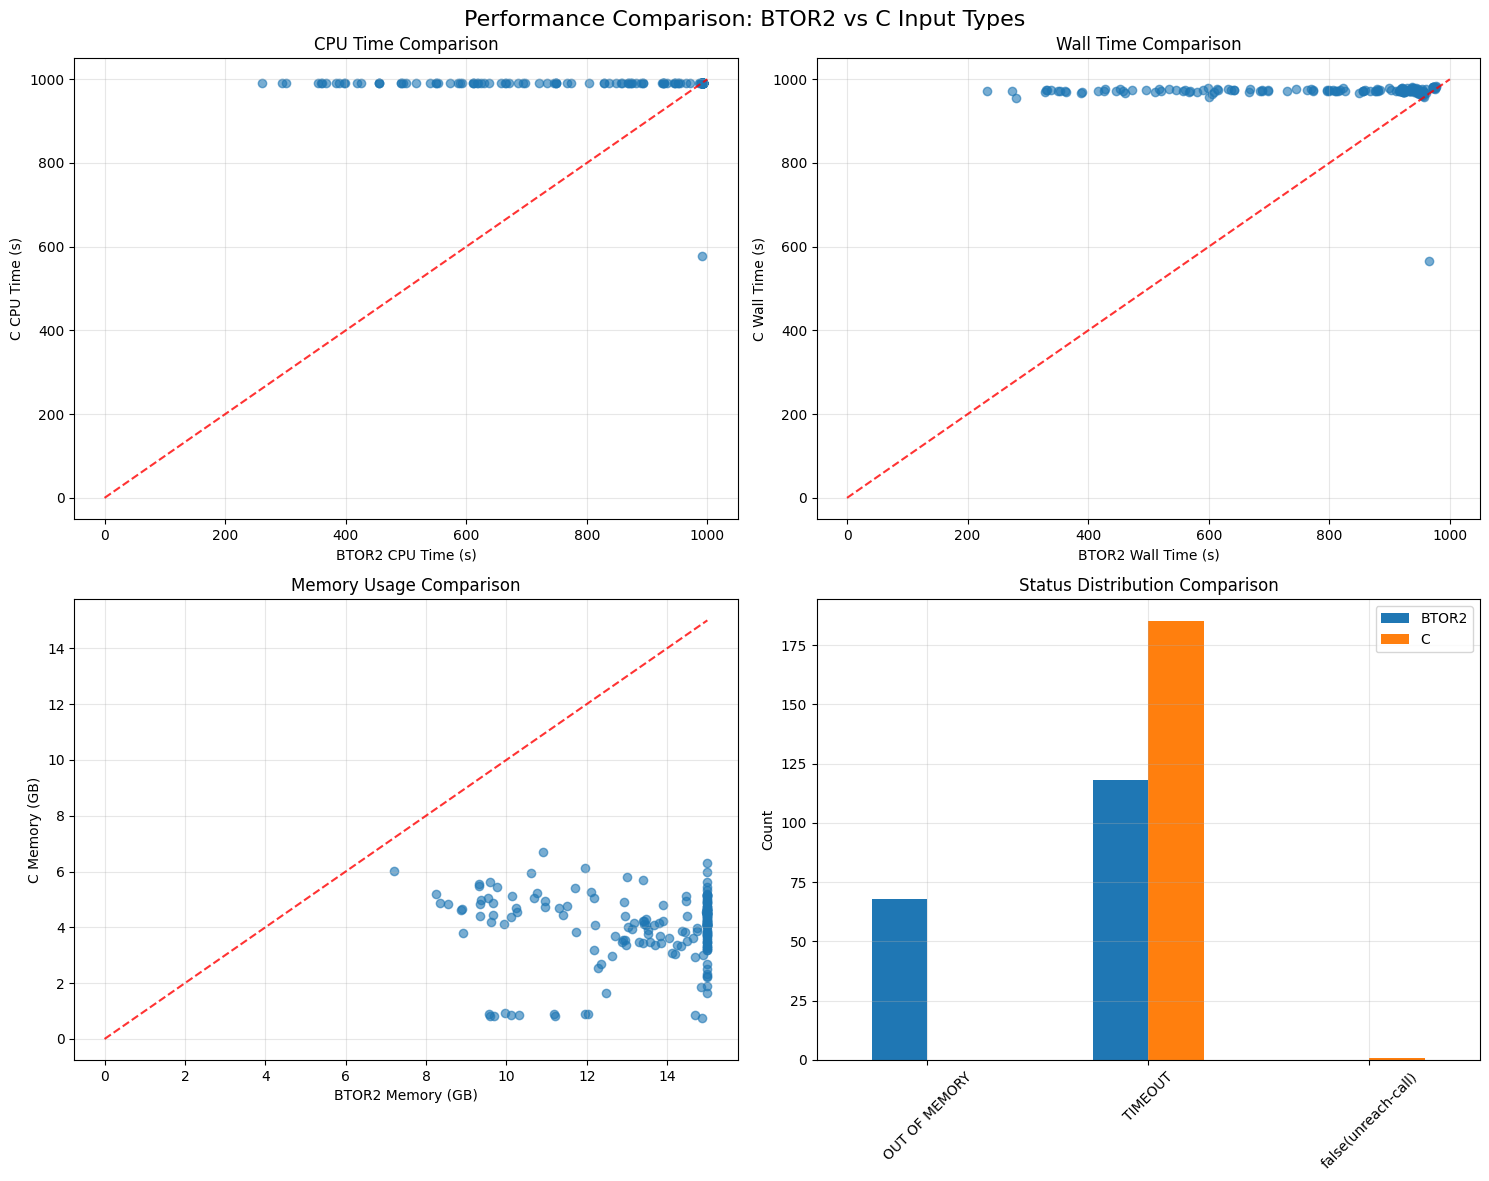

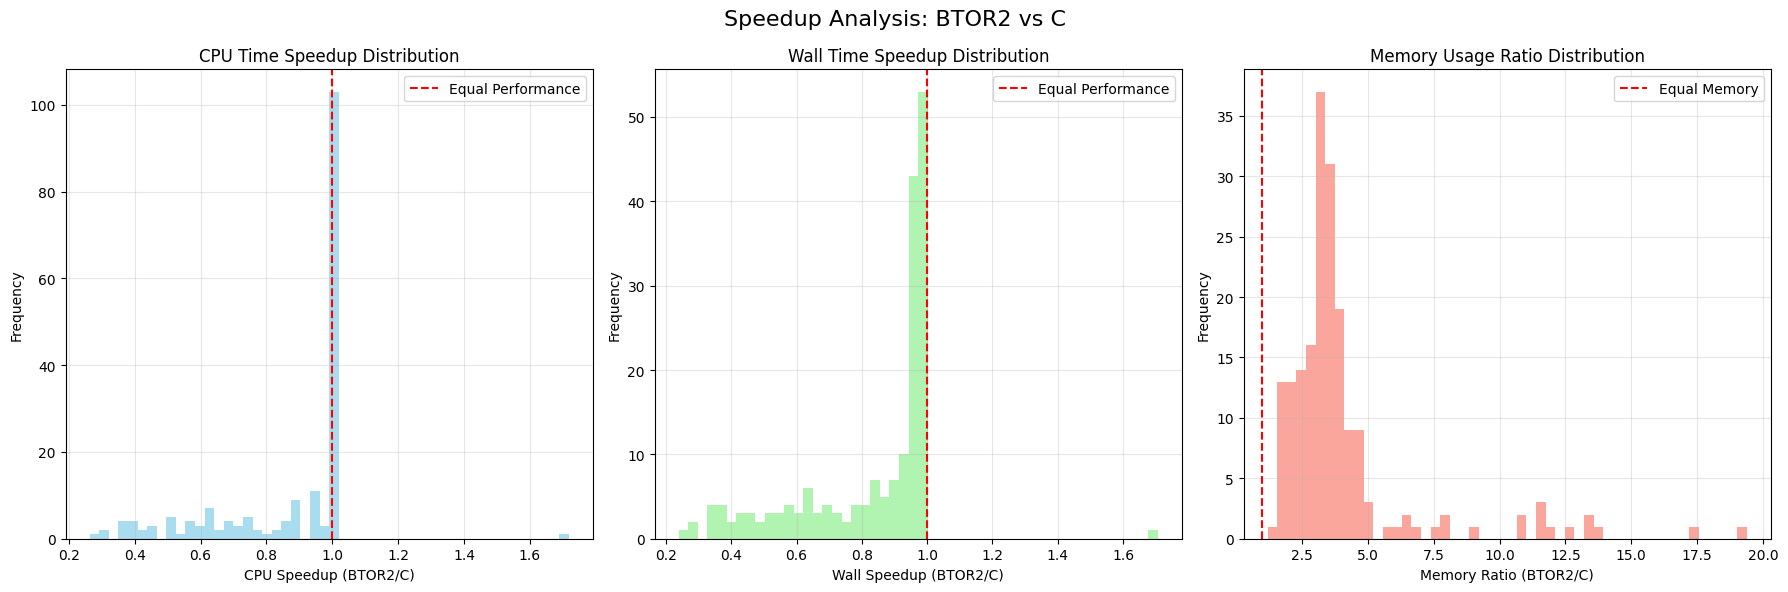


Speedup Analysis Summary:
Average CPU Speedup: 0.87
Average Wall Speedup: 0.83
Average Memory Ratio: 4.05


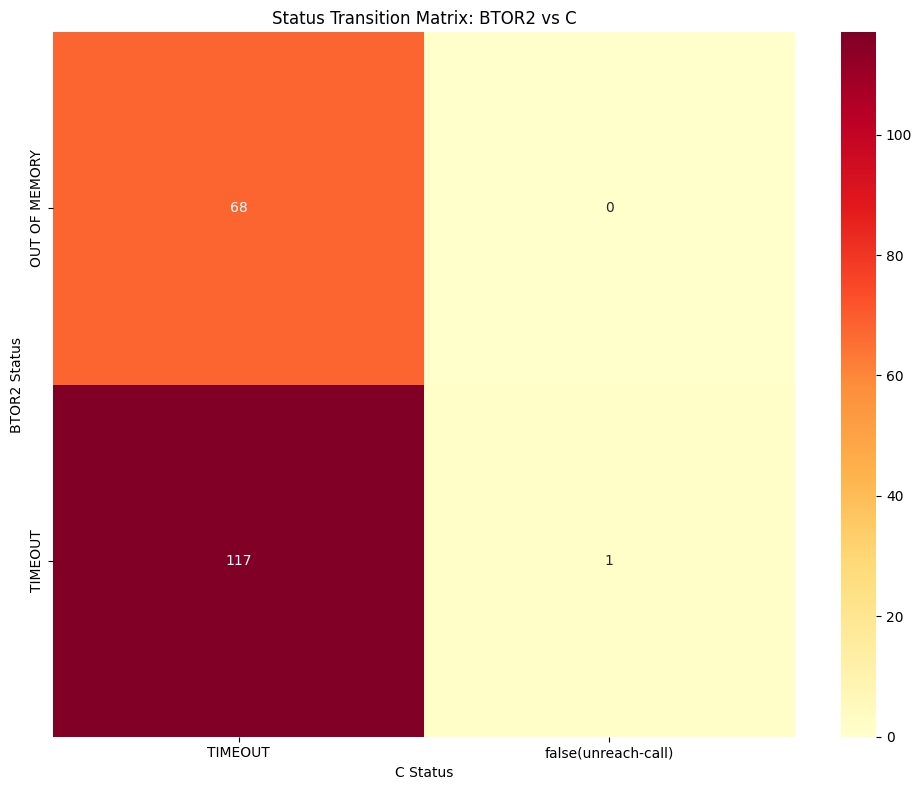

BENCHMARK COMPARISON SUMMARY REPORT

Total Benchmarks Compared: 186

Status Distribution:
BTOR2:
status_btor2
TIMEOUT          118
OUT OF MEMORY     68
Name: count, dtype: int64

C:
status_c
TIMEOUT                185
false(unreach-call)      1
Name: count, dtype: int64

Performance Metrics (Average):
CPUTIME: BTOR2=854.29, C=988.42, Ratio=0.86
WALLTIME: BTOR2=807.06, C=970.27, Ratio=0.83
MEMORY: BTOR2=13391265087.31, C=4013126182.54, Ratio=3.34

Success Rates:
BTOR2: 36.6%
C: 0.5%

Detailed comparison saved to 'detailed_comparison.csv'

Analysis complete! Check the generated PNG files for visualizations.


In [8]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import os

class BenchmarkComparator:
    def __init__(self):
        self.df_btor2 = None
        self.df_c = None
        self.comparison_df = None
        
    def parse_xml_file(self, file_path, input_type):
        """Parse XML file and extract benchmark results"""
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        data = []
        for run in root.findall('run'):
            # Extract benchmark name and properties
            run_name = run.get('name', '')
            properties = run.get('properties', '')
            expected_verdict = run.get('expectedVerdict', '')
            
            # Extract column values
            columns = {}
            for col in run.findall('column'):
                title = col.get('title')
                value = col.get('value')
                columns[title] = value
            
            # Extract file information
            files_elem = run.get('files', '[]')
            
            row_data = {
                'input_type': input_type,
                'run_name': run_name,
                'properties': properties,
                'expected_verdict': expected_verdict,
                'status': columns.get('status', ''),
                'cputime': float(columns.get('cputime', '0').replace('s', '')) if columns.get('cputime') else 0,
                'walltime': float(columns.get('walltime', '0').replace('s', '')) if columns.get('walltime') else 0,
                'memory': int(columns.get('memory', '0').replace('B', '')) if columns.get('memory') else 0,
                'host': columns.get('host', ''),
                'files': files_elem
            }
            
            data.append(row_data)
        
        return pd.DataFrame(data)
    
    def load_data(self, btor2_file, c_file):
        """Load both XML files"""
        self.df_btor2 = self.parse_xml_file(btor2_file, 'btor2')
        self.df_c = self.parse_xml_file(c_file, 'c')
        
        print(f"Loaded {len(self.df_btor2)} BTOR2 benchmarks")
        print(f"Loaded {len(self.df_c)} C benchmarks")
    
    def create_comparison_dataframe(self):
        """Create a combined dataframe for comparison"""
        # Extract benchmark identifiers for matching
        def extract_benchmark_id(run_name):
            # Extract the core benchmark name (e.g., "adding.1.prop1" from the full path)
            parts = run_name.split('/')
            for part in parts:
                if any(x in part for x in ['adding', 'anderson', 'at', 'bakery', 'blocks', 'bridge', 'brp']):
                    return part.replace('.yml', '')
            return run_name
        
        # Add benchmark IDs
        self.df_btor2['benchmark_id'] = self.df_btor2['run_name'].apply(extract_benchmark_id)
        self.df_c['benchmark_id'] = self.df_c['run_name'].apply(extract_benchmark_id)
        
        # Merge dataframes on benchmark_id
        merged = pd.merge(
            self.df_btor2, 
            self.df_c, 
            on='benchmark_id', 
            suffixes=('_btor2', '_c'),
            how='inner'
        )
        
        self.comparison_df = merged
        print(f"Successfully matched {len(merged)} benchmarks")
        
        return merged
    
    def create_performance_comparison_plot(self):
        """Create performance comparison plots"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Performance Comparison: BTOR2 vs C Input Types', fontsize=16)
        
        # CPU Time Comparison
        axes[0, 0].scatter(self.comparison_df['cputime_btor2'], 
                          self.comparison_df['cputime_c'], alpha=0.6)
        axes[0, 0].plot([0, 1000], [0, 1000], 'r--', alpha=0.8)
        axes[0, 0].set_xlabel('BTOR2 CPU Time (s)')
        axes[0, 0].set_ylabel('C CPU Time (s)')
        axes[0, 0].set_title('CPU Time Comparison')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Wall Time Comparison
        axes[0, 1].scatter(self.comparison_df['walltime_btor2'], 
                          self.comparison_df['walltime_c'], alpha=0.6)
        axes[0, 1].plot([0, 1000], [0, 1000], 'r--', alpha=0.8)
        axes[0, 1].set_xlabel('BTOR2 Wall Time (s)')
        axes[0, 1].set_ylabel('C Wall Time (s)')
        axes[0, 1].set_title('Wall Time Comparison')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Memory Usage Comparison
        axes[1, 0].scatter(self.comparison_df['memory_btor2']/1e9, 
                          self.comparison_df['memory_c']/1e9, alpha=0.6)
        axes[1, 0].plot([0, 15], [0, 15], 'r--', alpha=0.8)
        axes[1, 0].set_xlabel('BTOR2 Memory (GB)')
        axes[1, 0].set_ylabel('C Memory (GB)')
        axes[1, 0].set_title('Memory Usage Comparison')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Status Distribution
        status_counts = pd.DataFrame({
            'BTOR2': self.comparison_df['status_btor2'].value_counts(),
            'C': self.comparison_df['status_c'].value_counts()
        }).fillna(0)
        
        status_counts.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Status Distribution Comparison')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_speedup_analysis(self):
        """Analyze speedup factors"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        # Calculate speedup factors
        self.comparison_df['cpu_speedup'] = self.comparison_df['cputime_btor2'] / self.comparison_df['cputime_c']
        self.comparison_df['wall_speedup'] = self.comparison_df['walltime_btor2'] / self.comparison_df['walltime_c']
        self.comparison_df['memory_ratio'] = self.comparison_df['memory_btor2'] / self.comparison_df['memory_c']
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Speedup Analysis: BTOR2 vs C', fontsize=16)
        
        # CPU Speedup distribution
        axes[0].hist(self.comparison_df['cpu_speedup'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='skyblue')
        axes[0].axvline(1, color='red', linestyle='--', label='Equal Performance')
        axes[0].set_xlabel('CPU Speedup (BTOR2/C)')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('CPU Time Speedup Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Wall Speedup distribution
        axes[1].hist(self.comparison_df['wall_speedup'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='lightgreen')
        axes[1].axvline(1, color='red', linestyle='--', label='Equal Performance')
        axes[1].set_xlabel('Wall Speedup (BTOR2/C)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Wall Time Speedup Distribution')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Memory ratio distribution
        axes[2].hist(self.comparison_df['memory_ratio'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='salmon')
        axes[2].axvline(1, color='red', linestyle='--', label='Equal Memory')
        axes[2].set_xlabel('Memory Ratio (BTOR2/C)')
        axes[2].set_ylabel('Frequency')
        axes[2].set_title('Memory Usage Ratio Distribution')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('speedup_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print summary statistics
        print("\nSpeedup Analysis Summary:")
        print(f"Average CPU Speedup: {self.comparison_df['cpu_speedup'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
        print(f"Average Wall Speedup: {self.comparison_df['wall_speedup'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
        print(f"Average Memory Ratio: {self.comparison_df['memory_ratio'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
    
    def create_status_comparison_matrix(self):
        """Create a matrix showing status transitions between input types"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        status_matrix = pd.crosstab(
            self.comparison_df['status_btor2'], 
            self.comparison_df['status_c'],
            margins=True
        )
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(status_matrix.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlOrRd')
        plt.title('Status Transition Matrix: BTOR2 vs C')
        plt.xlabel('C Status')
        plt.ylabel('BTOR2 Status')
        plt.tight_layout()
        plt.savefig('status_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return status_matrix
    
    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        print("="*60)
        print("BENCHMARK COMPARISON SUMMARY REPORT")
        print("="*60)
        
        # Basic statistics
        print(f"\nTotal Benchmarks Compared: {len(self.comparison_df)}")
        
        # Status summary
        print("\nStatus Distribution:")
        print("BTOR2:")
        print(self.comparison_df['status_btor2'].value_counts())
        print("\nC:")
        print(self.comparison_df['status_c'].value_counts())
        
        # Performance metrics
        print("\nPerformance Metrics (Average):")
        metrics = ['cputime', 'walltime', 'memory']
        for metric in metrics:
            btor2_avg = self.comparison_df[f'{metric}_btor2'].mean()
            c_avg = self.comparison_df[f'{metric}_c'].mean()
            ratio = btor2_avg / c_avg if c_avg > 0 else float('inf')
            print(f"{metric.upper()}: BTOR2={btor2_avg:.2f}, C={c_avg:.2f}, Ratio={ratio:.2f}")
        
        # Success rate comparison
        btor2_success = len(self.comparison_df[self.comparison_df['status_btor2'] != 'TIMEOUT'])
        c_success = len(self.comparison_df[self.comparison_df['status_c'] != 'TIMEOUT'])
        
        print(f"\nSuccess Rates:")
        print(f"BTOR2: {btor2_success/len(self.comparison_df)*100:.1f}%")
        print(f"C: {c_success/len(self.comparison_df)*100:.1f}%")
        
        # Save detailed comparison to CSV
        self.comparison_df.to_csv('detailed_comparison.csv', index=False)
        print(f"\nDetailed comparison saved to 'detailed_comparison.csv'")

# Example usage
def main():
    # Initialize comparator
    comparator = BenchmarkComparator()
    
    # Load your XML files (replace with actual file paths)
    btor2_file = "result_xmls\\theta_algos.2025-10-29_06-24-29.results.btor2-bounded.btor2.xml"
    c_file = "result_xmls\\theta_algos.2025-10-29_06-24-29.results.c-bit-bounded.c-bit.xml"  # Your C input type file
    
    try:
        # Load data
        comparator.load_data(btor2_file, c_file)
        
        # Generate all analyses
        comparator.create_comparison_dataframe()
        comparator.create_performance_comparison_plot()
        comparator.create_speedup_analysis()
        status_matrix = comparator.create_status_comparison_matrix()
        comparator.generate_summary_report()
        
        print("\nAnalysis complete! Check the generated PNG files for visualizations.")
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please make sure both XML files are in the correct path.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## Explicit value based CEGAR

Loaded 693 BTOR2 benchmarks
Loaded 693 C benchmarks
Successfully matched 693 benchmarks


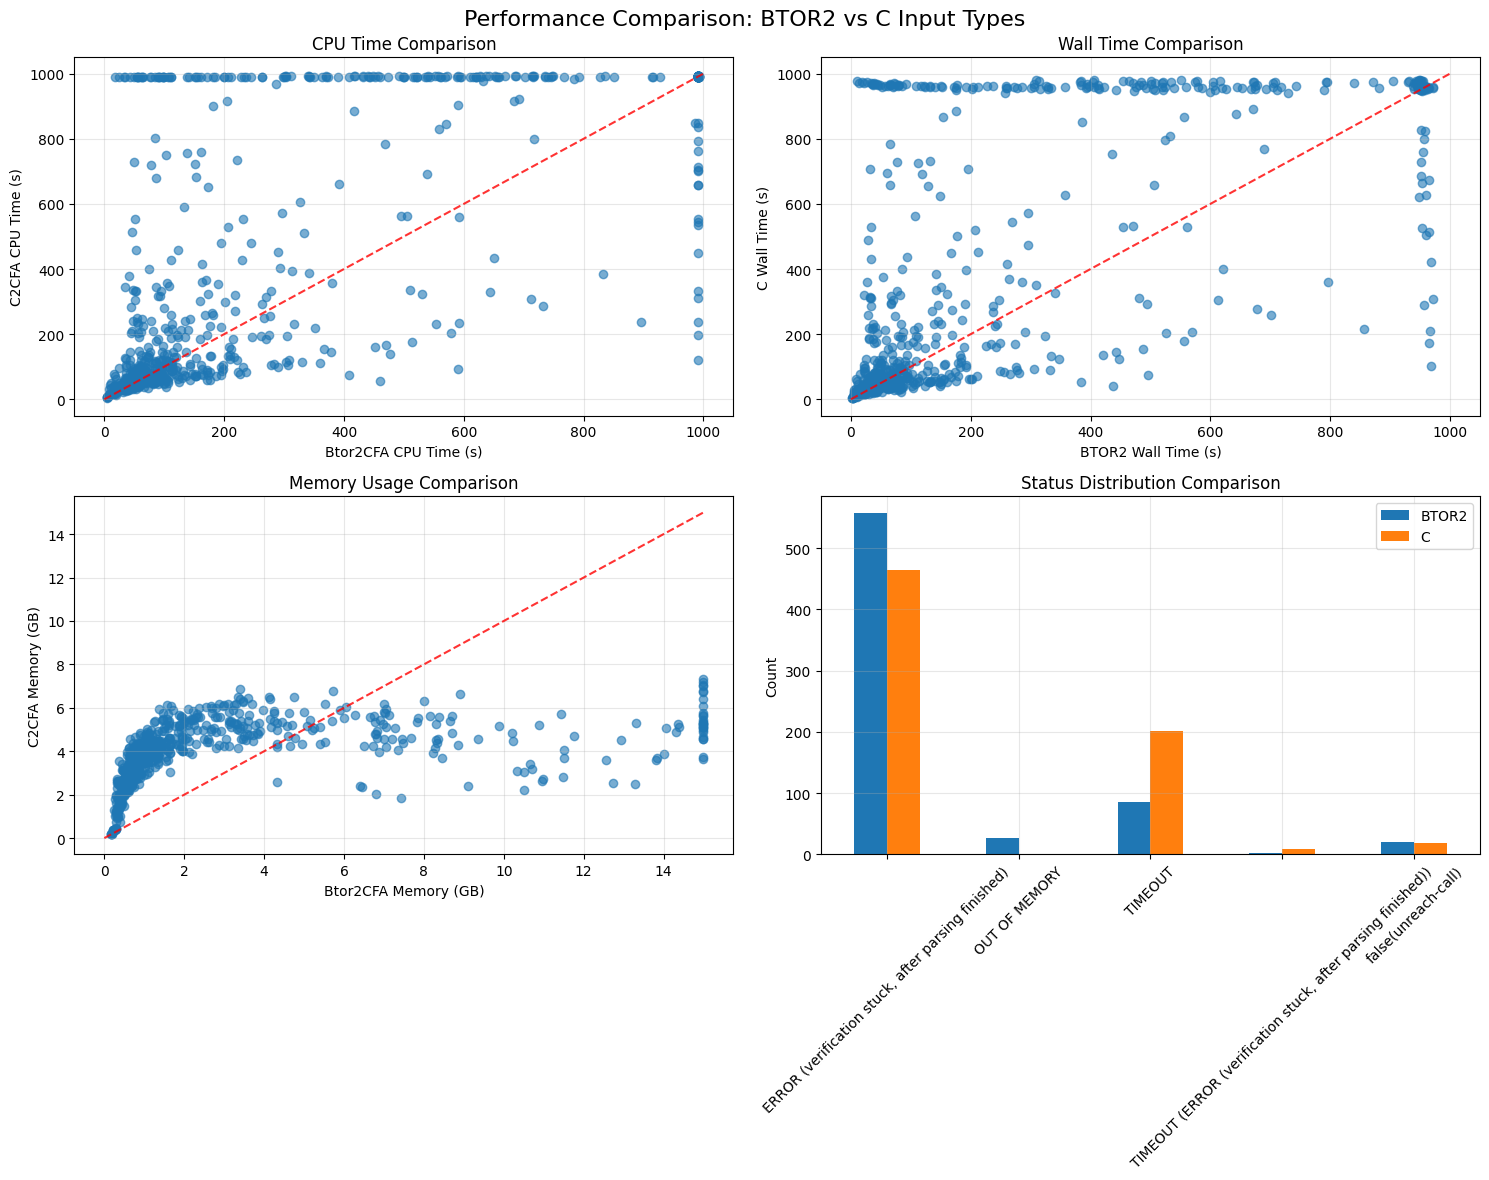

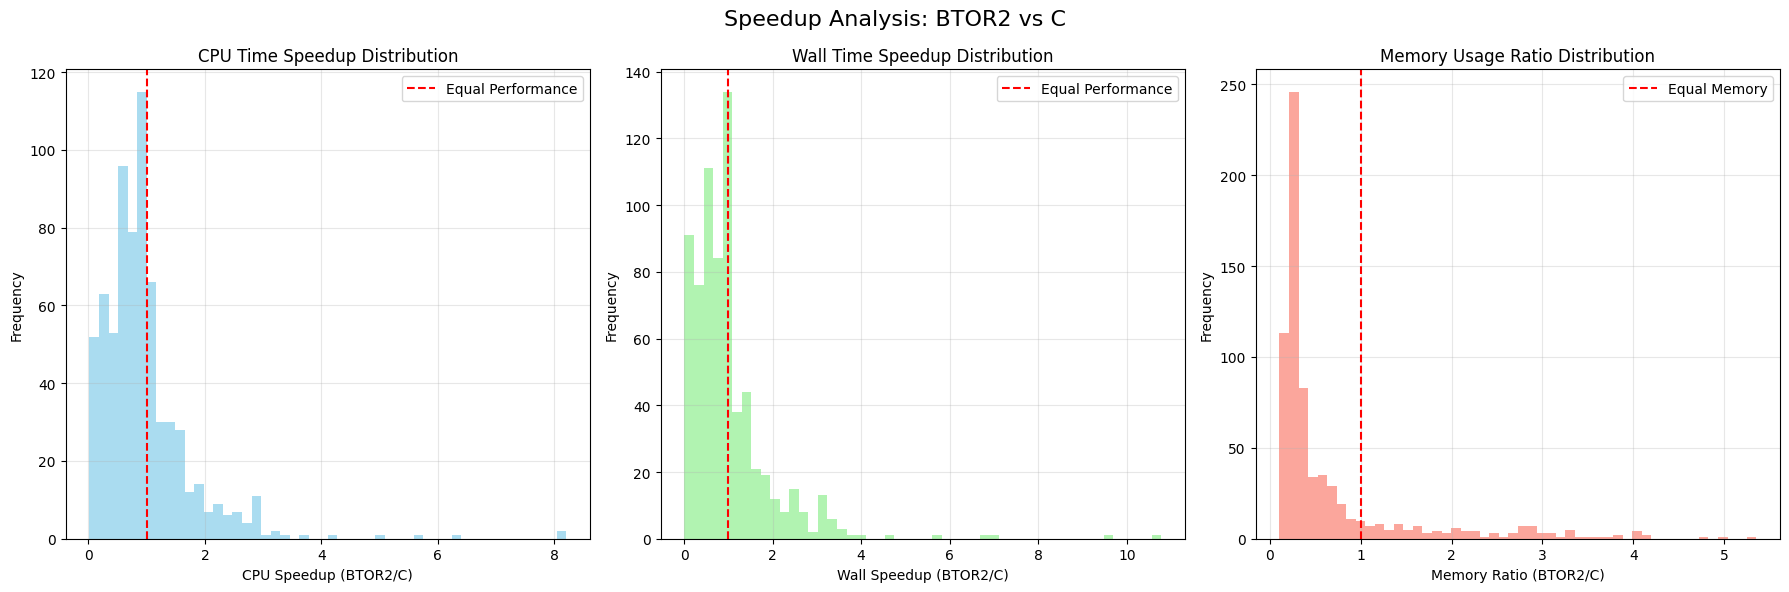


Speedup Analysis Summary:
Average CPU Speedup: 0.97
Average Wall Speedup: 1.01
Average Memory Ratio: 0.67


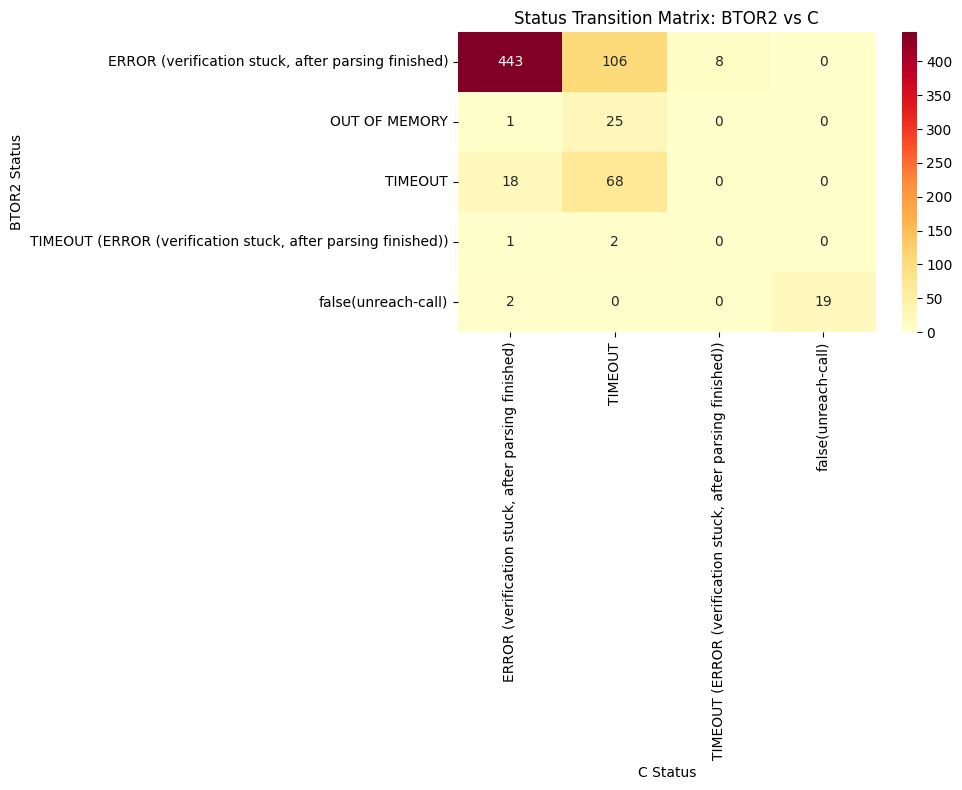

BENCHMARK COMPARISON SUMMARY REPORT

Total Benchmarks Compared: 693

Status Distribution:
BTOR2:
status_btor2
ERROR (verification stuck, after parsing finished)              557
TIMEOUT                                                          86
OUT OF MEMORY                                                    26
false(unreach-call)                                              21
TIMEOUT (ERROR (verification stuck, after parsing finished))      3
Name: count, dtype: int64

C:
status_c
ERROR (verification stuck, after parsing finished)              465
TIMEOUT                                                         201
false(unreach-call)                                              19
TIMEOUT (ERROR (verification stuck, after parsing finished))      8
Name: count, dtype: int64

Performance Metrics (Average):
CPUTIME: BTOR2=292.42, C=416.65, Ratio=0.70
WALLTIME: BTOR2=265.76, C=393.22, Ratio=0.68
MEMORY: BTOR2=2826453890.40, C=3848679879.11, Ratio=0.73

Success Rates:
BTOR2: 87.6%
C: 71.

In [4]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import os

class BenchmarkComparator:
    def __init__(self):
        self.df_btor2 = None
        self.df_c = None
        self.comparison_df = None
        
    def parse_xml_file(self, file_path, input_type):
        """Parse XML file and extract benchmark results"""
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        data = []
        for run in root.findall('run'):
            # Extract benchmark name and properties
            run_name = run.get('name', '')
            properties = run.get('properties', '')
            expected_verdict = run.get('expectedVerdict', '')
            
            # Extract column values
            columns = {}
            for col in run.findall('column'):
                title = col.get('title')
                value = col.get('value')
                columns[title] = value
            
            # Extract file information
            files_elem = run.get('files', '[]')
            
            row_data = {
                'input_type': input_type,
                'run_name': run_name,
                'properties': properties,
                'expected_verdict': expected_verdict,
                'status': columns.get('status', ''),
                'cputime': float(columns.get('cputime', '0').replace('s', '')) if columns.get('cputime') else 0,
                'walltime': float(columns.get('walltime', '0').replace('s', '')) if columns.get('walltime') else 0,
                'memory': int(columns.get('memory', '0').replace('B', '')) if columns.get('memory') else 0,
                'host': columns.get('host', ''),
                'files': files_elem
            }
            
            data.append(row_data)
        
        return pd.DataFrame(data)
    
    def load_data(self, btor2_file, c_file):
        """Load both XML files"""
        self.df_btor2 = self.parse_xml_file(btor2_file, 'btor2')
        self.df_c = self.parse_xml_file(c_file, 'c')
        
        print(f"Loaded {len(self.df_btor2)} BTOR2 benchmarks")
        print(f"Loaded {len(self.df_c)} C benchmarks")
    
    def create_comparison_dataframe(self):
        """Create a combined dataframe for comparison"""
        # Extract benchmark identifiers for matching
        def extract_benchmark_id(run_name):
            # Extract the core benchmark name (e.g., "adding.1.prop1" from the full path)
            start = run_name.rfind("/") + 1
            end = run_name.rfind(".yml")
            return run_name[start:end] if end != -1 else run_name[start:]
        
        # Add benchmark IDs
        self.df_btor2['benchmark_id'] = self.df_btor2['run_name'].apply(extract_benchmark_id)
        self.df_c['benchmark_id'] = self.df_c['run_name'].apply(extract_benchmark_id)
        
        # Merge dataframes on benchmark_id
        merged = pd.merge(
            self.df_btor2, 
            self.df_c, 
            on='benchmark_id', 
            suffixes=('_btor2', '_c'),
            how='inner'
        )
        
        self.comparison_df = merged
        print(f"Successfully matched {len(merged)} benchmarks")
        
        return merged
    
    def create_performance_comparison_plot(self):
        """Create performance comparison plots"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Performance Comparison: BTOR2 vs C Input Types', fontsize=16)
        
        # CPU Time Comparison
        axes[0, 0].scatter(self.comparison_df['cputime_btor2'], 
                          self.comparison_df['cputime_c'], alpha=0.6)
        axes[0, 0].plot([0, 1000], [0, 1000], 'r--', alpha=0.8)
        axes[0, 0].set_xlabel('Btor2CFA CPU Time (s)')
        axes[0, 0].set_ylabel('C2CFA CPU Time (s)')
        axes[0, 0].set_title('CPU Time Comparison')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Wall Time Comparison
        axes[0, 1].scatter(self.comparison_df['walltime_btor2'], 
                          self.comparison_df['walltime_c'], alpha=0.6)
        axes[0, 1].plot([0, 1000], [0, 1000], 'r--', alpha=0.8)
        axes[0, 1].set_xlabel('BTOR2 Wall Time (s)')
        axes[0, 1].set_ylabel('C Wall Time (s)')
        axes[0, 1].set_title('Wall Time Comparison')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Memory Usage Comparison
        axes[1, 0].scatter(self.comparison_df['memory_btor2']/1e9, 
                          self.comparison_df['memory_c']/1e9, alpha=0.6)
        axes[1, 0].plot([0, 15], [0, 15], 'r--', alpha=0.8)
        axes[1, 0].set_xlabel('Btor2CFA Memory (GB)')
        axes[1, 0].set_ylabel('C2CFA Memory (GB)')
        axes[1, 0].set_title('Memory Usage Comparison')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Status Distribution
        status_counts = pd.DataFrame({
            'BTOR2': self.comparison_df['status_btor2'].value_counts(),
            'C': self.comparison_df['status_c'].value_counts()
        }).fillna(0)
        
        status_counts.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Status Distribution Comparison')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_speedup_analysis(self):
        """Analyze speedup factors"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        # Calculate speedup factors
        self.comparison_df['cpu_speedup'] = self.comparison_df['cputime_btor2'] / self.comparison_df['cputime_c']
        self.comparison_df['wall_speedup'] = self.comparison_df['walltime_btor2'] / self.comparison_df['walltime_c']
        self.comparison_df['memory_ratio'] = self.comparison_df['memory_btor2'] / self.comparison_df['memory_c']
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Speedup Analysis: BTOR2 vs C', fontsize=16)
        
        # CPU Speedup distribution
        axes[0].hist(self.comparison_df['cpu_speedup'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='skyblue')
        axes[0].axvline(1, color='red', linestyle='--', label='Equal Performance')
        axes[0].set_xlabel('CPU Speedup (BTOR2/C)')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('CPU Time Speedup Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Wall Speedup distribution
        axes[1].hist(self.comparison_df['wall_speedup'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='lightgreen')
        axes[1].axvline(1, color='red', linestyle='--', label='Equal Performance')
        axes[1].set_xlabel('Wall Speedup (BTOR2/C)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Wall Time Speedup Distribution')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Memory ratio distribution
        axes[2].hist(self.comparison_df['memory_ratio'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='salmon')
        axes[2].axvline(1, color='red', linestyle='--', label='Equal Memory')
        axes[2].set_xlabel('Memory Ratio (BTOR2/C)')
        axes[2].set_ylabel('Frequency')
        axes[2].set_title('Memory Usage Ratio Distribution')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('speedup_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print summary statistics
        print("\nSpeedup Analysis Summary:")
        print(f"Average CPU Speedup: {self.comparison_df['cpu_speedup'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
        print(f"Average Wall Speedup: {self.comparison_df['wall_speedup'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
        print(f"Average Memory Ratio: {self.comparison_df['memory_ratio'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
    
    def create_status_comparison_matrix(self):
        """Create a matrix showing status transitions between input types"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        status_matrix = pd.crosstab(
            self.comparison_df['status_btor2'], 
            self.comparison_df['status_c'],
            margins=True
        )
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(status_matrix.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlOrRd')
        plt.title('Status Transition Matrix: BTOR2 vs C')
        plt.xlabel('C Status')
        plt.ylabel('BTOR2 Status')
        plt.tight_layout()
        plt.savefig('status_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return status_matrix
    
    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        print("="*60)
        print("BENCHMARK COMPARISON SUMMARY REPORT")
        print("="*60)
        
        # Basic statistics
        print(f"\nTotal Benchmarks Compared: {len(self.comparison_df)}")
        
        # Status summary
        print("\nStatus Distribution:")
        print("BTOR2:")
        print(self.comparison_df['status_btor2'].value_counts())
        print("\nC:")
        print(self.comparison_df['status_c'].value_counts())
        
        # Performance metrics
        print("\nPerformance Metrics (Average):")
        metrics = ['cputime', 'walltime', 'memory']
        for metric in metrics:
            btor2_avg = self.comparison_df[f'{metric}_btor2'].mean()
            c_avg = self.comparison_df[f'{metric}_c'].mean()
            ratio = btor2_avg / c_avg if c_avg > 0 else float('inf')
            print(f"{metric.upper()}: BTOR2={btor2_avg:.2f}, C={c_avg:.2f}, Ratio={ratio:.2f}")
        
        # Success rate comparison
        btor2_success = len(self.comparison_df[self.comparison_df['status_btor2'] != 'TIMEOUT'])
        c_success = len(self.comparison_df[self.comparison_df['status_c'] != 'TIMEOUT'])
        
        print(f"\nSuccess Rates:")
        print(f"BTOR2: {btor2_success/len(self.comparison_df)*100:.1f}%")
        print(f"C: {c_success/len(self.comparison_df)*100:.1f}%")
        
        # Save detailed comparison to CSV
        self.comparison_df.to_csv('detailed_comparison.csv', index=False)
        print(f"\nDetailed comparison saved to 'detailed_comparison.csv'")

# Example usage
def main():
    # Initialize comparator
    comparator = BenchmarkComparator()
    
    # Load your XML files (replace with actual file paths)
    btor2_file = "result_xmls\\theta_algos.2025-10-29_06-24-29.results.btor2-expl-cegar.btor2-expl.xml"
    c_file = "result_xmls\\theta_algos.2025-10-29_06-24-29.results.c-bit-expl-cegar.c-bit-expl.xml"  # Your C input type file
    
    try:
        # Load data
        comparator.load_data(btor2_file, c_file)
        
        # Generate all analyses
        comparator.create_comparison_dataframe()
        comparator.create_performance_comparison_plot()
        comparator.create_speedup_analysis()
        status_matrix = comparator.create_status_comparison_matrix()
        comparator.generate_summary_report()
        
        print("\nAnalysis complete! Check the generated PNG files for visualizations.")
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please make sure both XML files are in the correct path.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## IC3

Loaded 693 BTOR2 benchmarks
Loaded 693 C benchmarks
Successfully matched 186 benchmarks


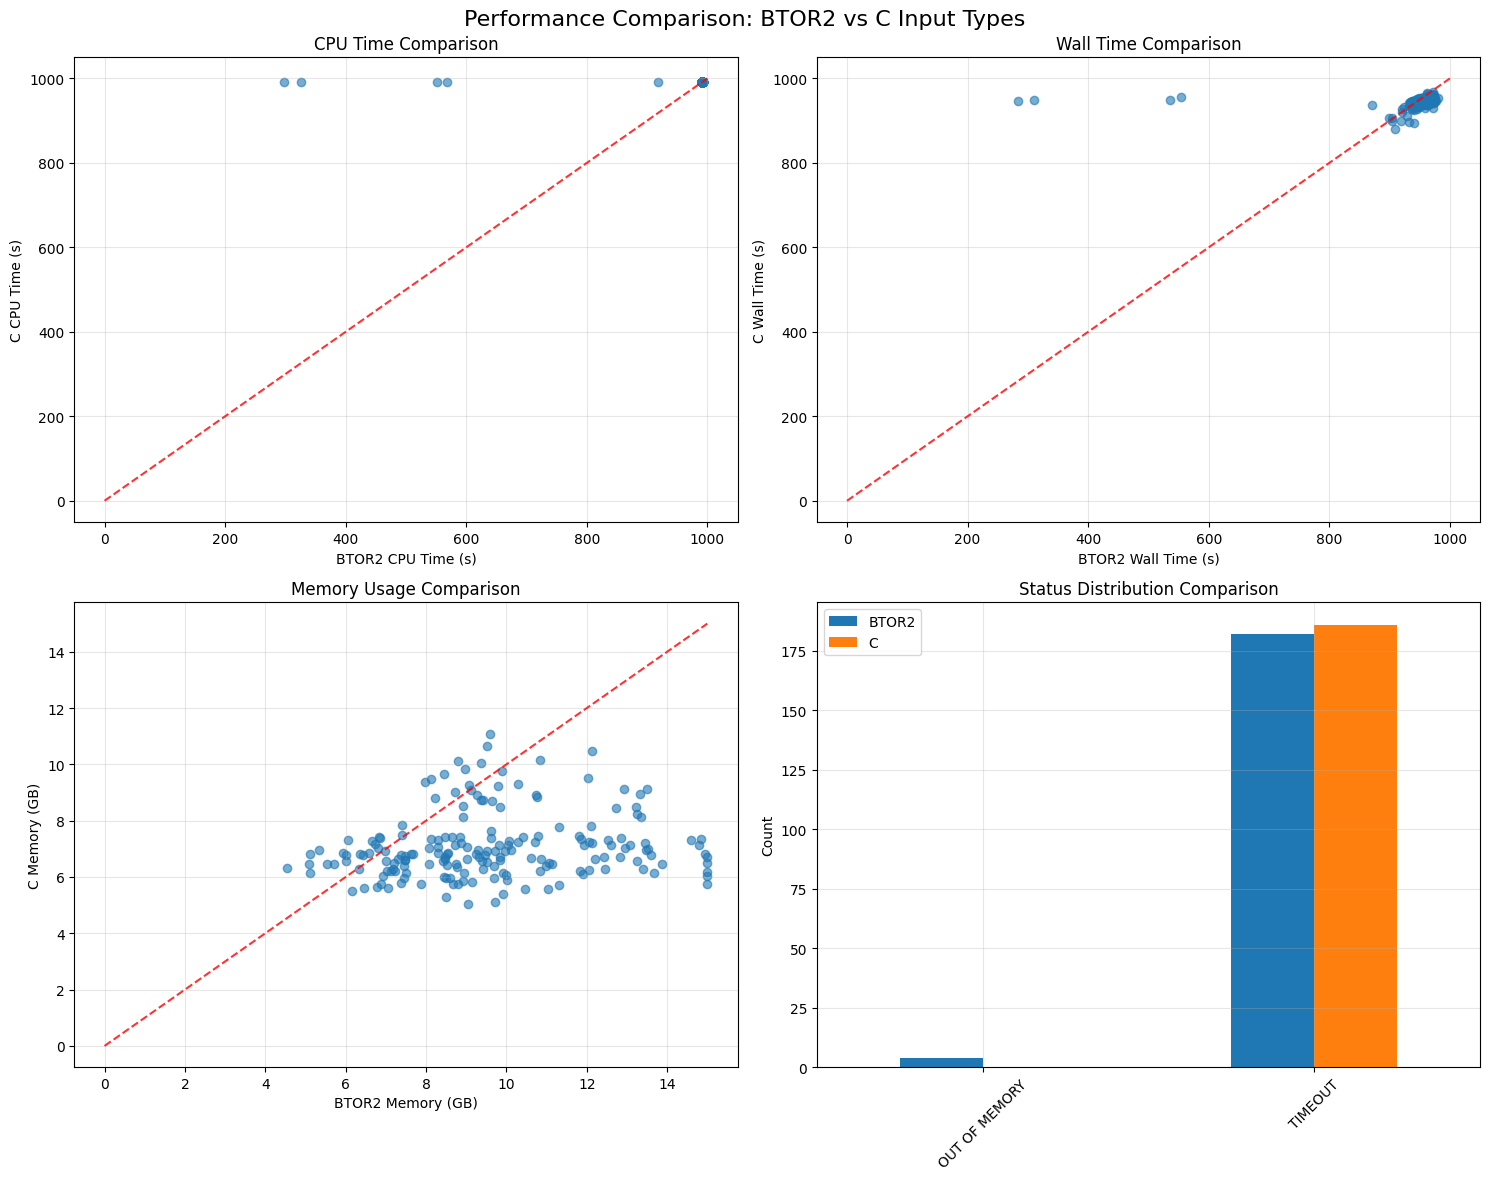

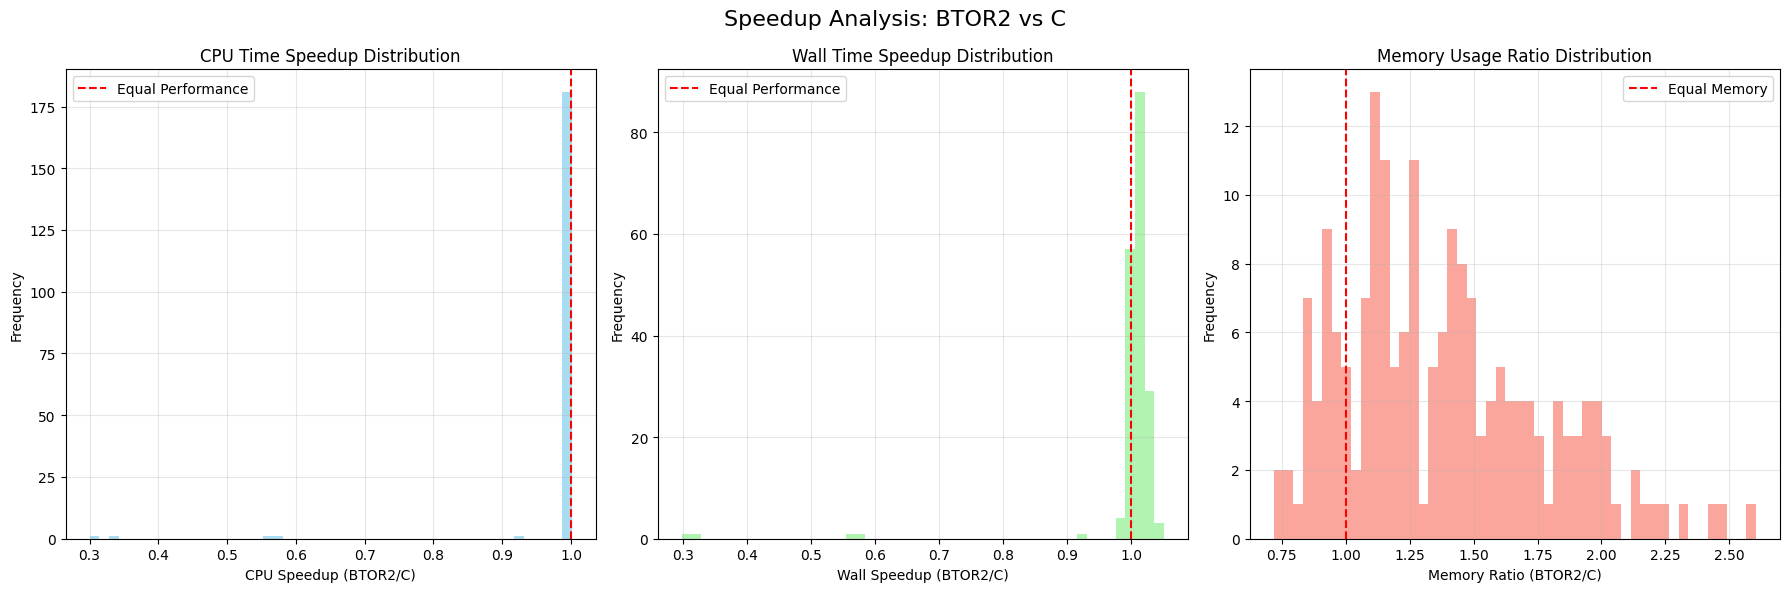


Speedup Analysis Summary:
Average CPU Speedup: 0.99
Average Wall Speedup: 1.00
Average Memory Ratio: 1.38


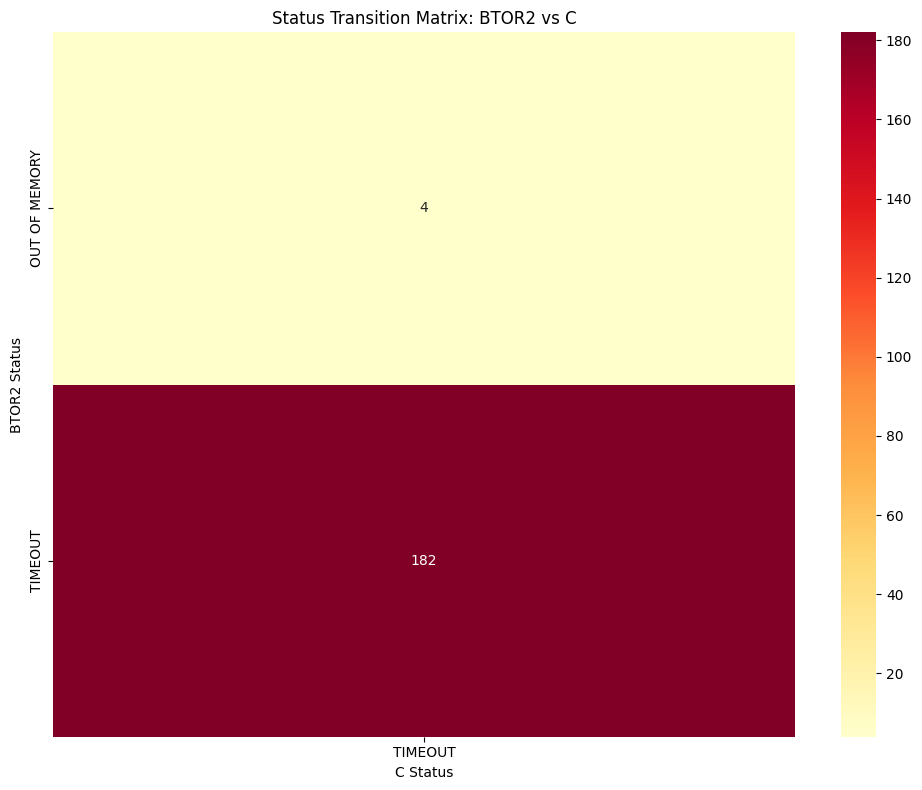

BENCHMARK COMPARISON SUMMARY REPORT

Total Benchmarks Compared: 186

Status Distribution:
BTOR2:
status_btor2
TIMEOUT          182
OUT OF MEMORY      4
Name: count, dtype: int64

C:
status_c
TIMEOUT    186
Name: count, dtype: int64

Performance Metrics (Average):
CPUTIME: BTOR2=979.08, C=991.46, Ratio=0.99
WALLTIME: BTOR2=940.26, C=942.44, Ratio=1.00
MEMORY: BTOR2=9624643760.17, C=7097608103.91, Ratio=1.36

Success Rates:
BTOR2: 2.2%
C: 0.0%

Detailed comparison saved to 'detailed_comparison.csv'

Analysis complete! Check the generated PNG files for visualizations.


In [10]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import os

class BenchmarkComparator:
    def __init__(self):
        self.df_btor2 = None
        self.df_c = None
        self.comparison_df = None
        
    def parse_xml_file(self, file_path, input_type):
        """Parse XML file and extract benchmark results"""
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        data = []
        for run in root.findall('run'):
            # Extract benchmark name and properties
            run_name = run.get('name', '')
            properties = run.get('properties', '')
            expected_verdict = run.get('expectedVerdict', '')
            
            # Extract column values
            columns = {}
            for col in run.findall('column'):
                title = col.get('title')
                value = col.get('value')
                columns[title] = value
            
            # Extract file information
            files_elem = run.get('files', '[]')
            
            row_data = {
                'input_type': input_type,
                'run_name': run_name,
                'properties': properties,
                'expected_verdict': expected_verdict,
                'status': columns.get('status', ''),
                'cputime': float(columns.get('cputime', '0').replace('s', '')) if columns.get('cputime') else 0,
                'walltime': float(columns.get('walltime', '0').replace('s', '')) if columns.get('walltime') else 0,
                'memory': int(columns.get('memory', '0').replace('B', '')) if columns.get('memory') else 0,
                'host': columns.get('host', ''),
                'files': files_elem
            }
            
            data.append(row_data)
        
        return pd.DataFrame(data)
    
    def load_data(self, btor2_file, c_file):
        """Load both XML files"""
        self.df_btor2 = self.parse_xml_file(btor2_file, 'btor2')
        self.df_c = self.parse_xml_file(c_file, 'c')
        
        print(f"Loaded {len(self.df_btor2)} BTOR2 benchmarks")
        print(f"Loaded {len(self.df_c)} C benchmarks")
    
    def create_comparison_dataframe(self):
        """Create a combined dataframe for comparison"""
        # Extract benchmark identifiers for matching
        def extract_benchmark_id(run_name):
            # Extract the core benchmark name (e.g., "adding.1.prop1" from the full path)
            parts = run_name.split('/')
            for part in parts:
                if any(x in part for x in ['adding', 'anderson', 'at', 'bakery', 'blocks', 'bridge', 'brp']):
                    return part.replace('.yml', '')
            return run_name
        
        # Add benchmark IDs
        self.df_btor2['benchmark_id'] = self.df_btor2['run_name'].apply(extract_benchmark_id)
        self.df_c['benchmark_id'] = self.df_c['run_name'].apply(extract_benchmark_id)
        
        # Merge dataframes on benchmark_id
        merged = pd.merge(
            self.df_btor2, 
            self.df_c, 
            on='benchmark_id', 
            suffixes=('_btor2', '_c'),
            how='inner'
        )
        
        self.comparison_df = merged
        print(f"Successfully matched {len(merged)} benchmarks")
        
        return merged
    
    def create_performance_comparison_plot(self):
        """Create performance comparison plots"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Performance Comparison: BTOR2 vs C Input Types', fontsize=16)
        
        # CPU Time Comparison
        axes[0, 0].scatter(self.comparison_df['cputime_btor2'], 
                          self.comparison_df['cputime_c'], alpha=0.6)
        axes[0, 0].plot([0, 1000], [0, 1000], 'r--', alpha=0.8)
        axes[0, 0].set_xlabel('BTOR2 CPU Time (s)')
        axes[0, 0].set_ylabel('C CPU Time (s)')
        axes[0, 0].set_title('CPU Time Comparison')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Wall Time Comparison
        axes[0, 1].scatter(self.comparison_df['walltime_btor2'], 
                          self.comparison_df['walltime_c'], alpha=0.6)
        axes[0, 1].plot([0, 1000], [0, 1000], 'r--', alpha=0.8)
        axes[0, 1].set_xlabel('BTOR2 Wall Time (s)')
        axes[0, 1].set_ylabel('C Wall Time (s)')
        axes[0, 1].set_title('Wall Time Comparison')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Memory Usage Comparison
        axes[1, 0].scatter(self.comparison_df['memory_btor2']/1e9, 
                          self.comparison_df['memory_c']/1e9, alpha=0.6)
        axes[1, 0].plot([0, 15], [0, 15], 'r--', alpha=0.8)
        axes[1, 0].set_xlabel('BTOR2 Memory (GB)')
        axes[1, 0].set_ylabel('C Memory (GB)')
        axes[1, 0].set_title('Memory Usage Comparison')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Status Distribution
        status_counts = pd.DataFrame({
            'BTOR2': self.comparison_df['status_btor2'].value_counts(),
            'C': self.comparison_df['status_c'].value_counts()
        }).fillna(0)
        
        status_counts.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Status Distribution Comparison')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_speedup_analysis(self):
        """Analyze speedup factors"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        # Calculate speedup factors
        self.comparison_df['cpu_speedup'] = self.comparison_df['cputime_btor2'] / self.comparison_df['cputime_c']
        self.comparison_df['wall_speedup'] = self.comparison_df['walltime_btor2'] / self.comparison_df['walltime_c']
        self.comparison_df['memory_ratio'] = self.comparison_df['memory_btor2'] / self.comparison_df['memory_c']
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Speedup Analysis: BTOR2 vs C', fontsize=16)
        
        # CPU Speedup distribution
        axes[0].hist(self.comparison_df['cpu_speedup'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='skyblue')
        axes[0].axvline(1, color='red', linestyle='--', label='Equal Performance')
        axes[0].set_xlabel('CPU Speedup (BTOR2/C)')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('CPU Time Speedup Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Wall Speedup distribution
        axes[1].hist(self.comparison_df['wall_speedup'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='lightgreen')
        axes[1].axvline(1, color='red', linestyle='--', label='Equal Performance')
        axes[1].set_xlabel('Wall Speedup (BTOR2/C)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Wall Time Speedup Distribution')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Memory ratio distribution
        axes[2].hist(self.comparison_df['memory_ratio'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='salmon')
        axes[2].axvline(1, color='red', linestyle='--', label='Equal Memory')
        axes[2].set_xlabel('Memory Ratio (BTOR2/C)')
        axes[2].set_ylabel('Frequency')
        axes[2].set_title('Memory Usage Ratio Distribution')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('speedup_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print summary statistics
        print("\nSpeedup Analysis Summary:")
        print(f"Average CPU Speedup: {self.comparison_df['cpu_speedup'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
        print(f"Average Wall Speedup: {self.comparison_df['wall_speedup'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
        print(f"Average Memory Ratio: {self.comparison_df['memory_ratio'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
    
    def create_status_comparison_matrix(self):
        """Create a matrix showing status transitions between input types"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        status_matrix = pd.crosstab(
            self.comparison_df['status_btor2'], 
            self.comparison_df['status_c'],
            margins=True
        )
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(status_matrix.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlOrRd')
        plt.title('Status Transition Matrix: BTOR2 vs C')
        plt.xlabel('C Status')
        plt.ylabel('BTOR2 Status')
        plt.tight_layout()
        plt.savefig('status_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return status_matrix
    
    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        print("="*60)
        print("BENCHMARK COMPARISON SUMMARY REPORT")
        print("="*60)
        
        # Basic statistics
        print(f"\nTotal Benchmarks Compared: {len(self.comparison_df)}")
        
        # Status summary
        print("\nStatus Distribution:")
        print("BTOR2:")
        print(self.comparison_df['status_btor2'].value_counts())
        print("\nC:")
        print(self.comparison_df['status_c'].value_counts())
        
        # Performance metrics
        print("\nPerformance Metrics (Average):")
        metrics = ['cputime', 'walltime', 'memory']
        for metric in metrics:
            btor2_avg = self.comparison_df[f'{metric}_btor2'].mean()
            c_avg = self.comparison_df[f'{metric}_c'].mean()
            ratio = btor2_avg / c_avg if c_avg > 0 else float('inf')
            print(f"{metric.upper()}: BTOR2={btor2_avg:.2f}, C={c_avg:.2f}, Ratio={ratio:.2f}")
        
        # Success rate comparison
        btor2_success = len(self.comparison_df[self.comparison_df['status_btor2'] != 'TIMEOUT'])
        c_success = len(self.comparison_df[self.comparison_df['status_c'] != 'TIMEOUT'])
        
        print(f"\nSuccess Rates:")
        print(f"BTOR2: {btor2_success/len(self.comparison_df)*100:.1f}%")
        print(f"C: {c_success/len(self.comparison_df)*100:.1f}%")
        
        # Save detailed comparison to CSV
        self.comparison_df.to_csv('detailed_comparison.csv', index=False)
        print(f"\nDetailed comparison saved to 'detailed_comparison.csv'")

# Example usage
def main():
    # Initialize comparator
    comparator = BenchmarkComparator()
    
    # Load your XML files (replace with actual file paths)
    btor2_file = "result_xmls\\theta_algos.2025-10-29_06-24-29.results.btor2-ic3.btor2.xml"
    c_file = "result_xmls\\theta_algos.2025-10-29_06-24-29.results.c-bit-ic3.c-bit.xml"  # Your C input type file
    
    try:
        # Load data
        comparator.load_data(btor2_file, c_file)
        
        # Generate all analyses
        comparator.create_comparison_dataframe()
        comparator.create_performance_comparison_plot()
        comparator.create_speedup_analysis()
        status_matrix = comparator.create_status_comparison_matrix()
        comparator.generate_summary_report()
        
        print("\nAnalysis complete! Check the generated PNG files for visualizations.")
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please make sure both XML files are in the correct path.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## IMC

Loaded 693 BTOR2 benchmarks
Loaded 693 C benchmarks
Successfully matched 186 benchmarks


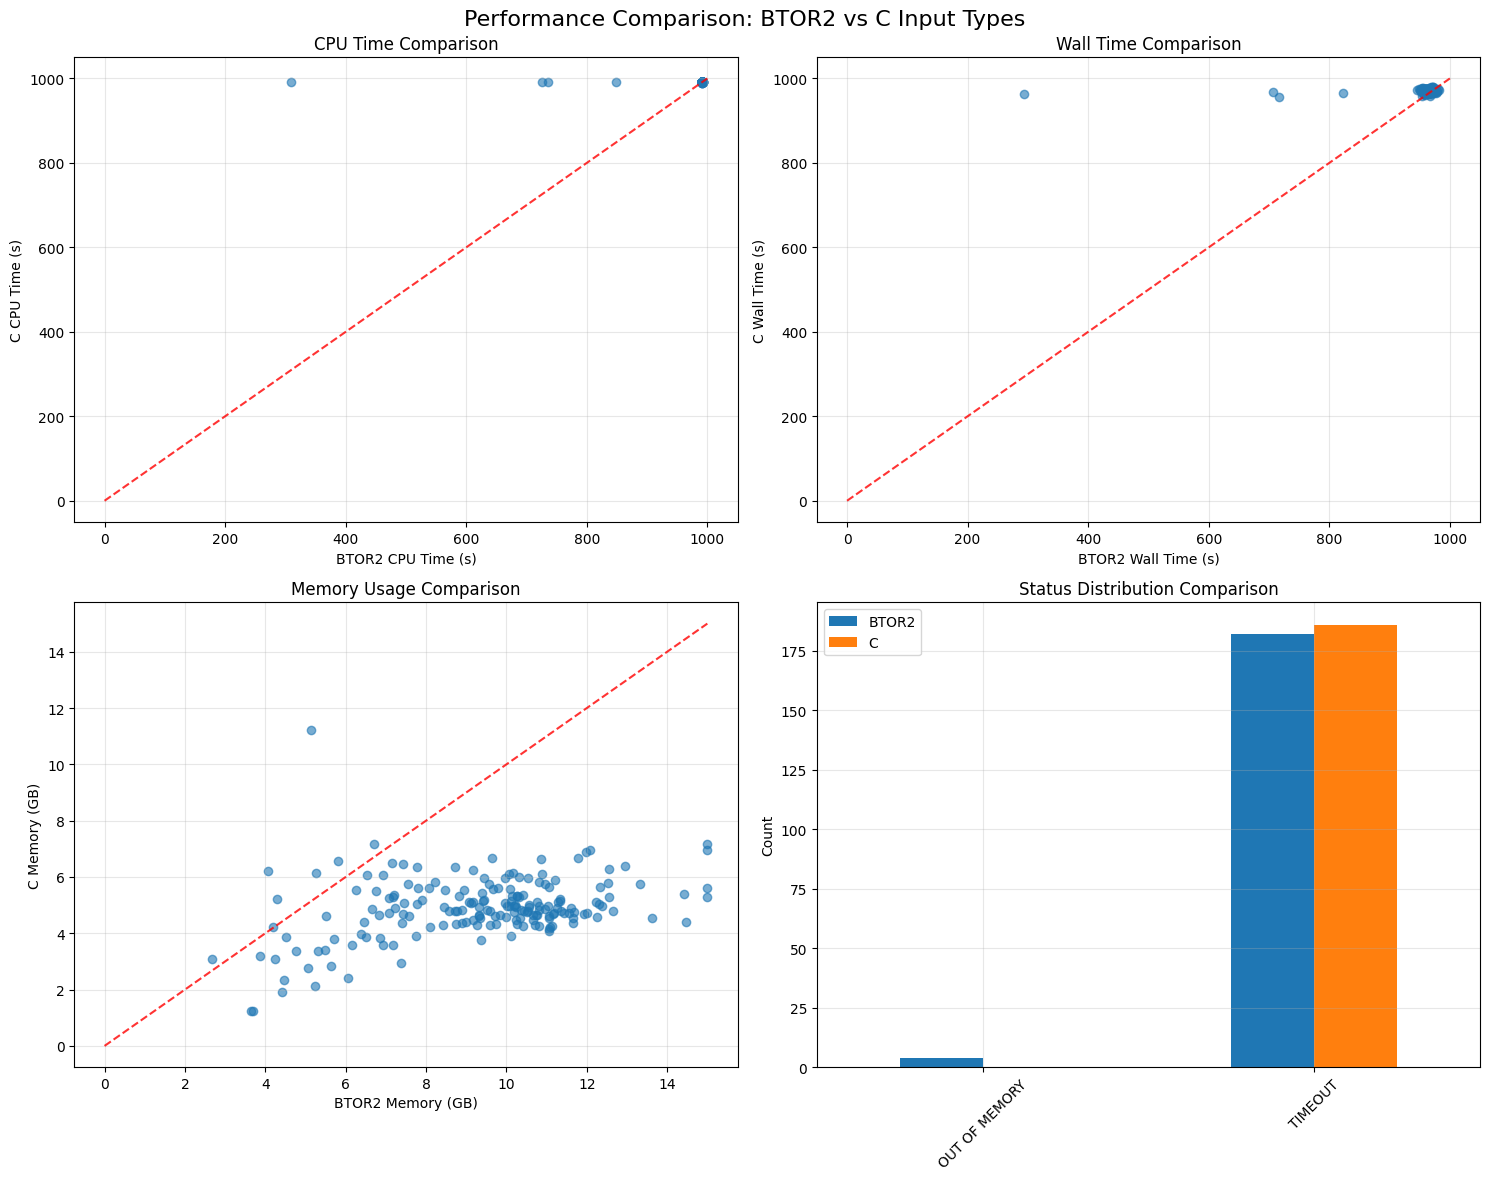

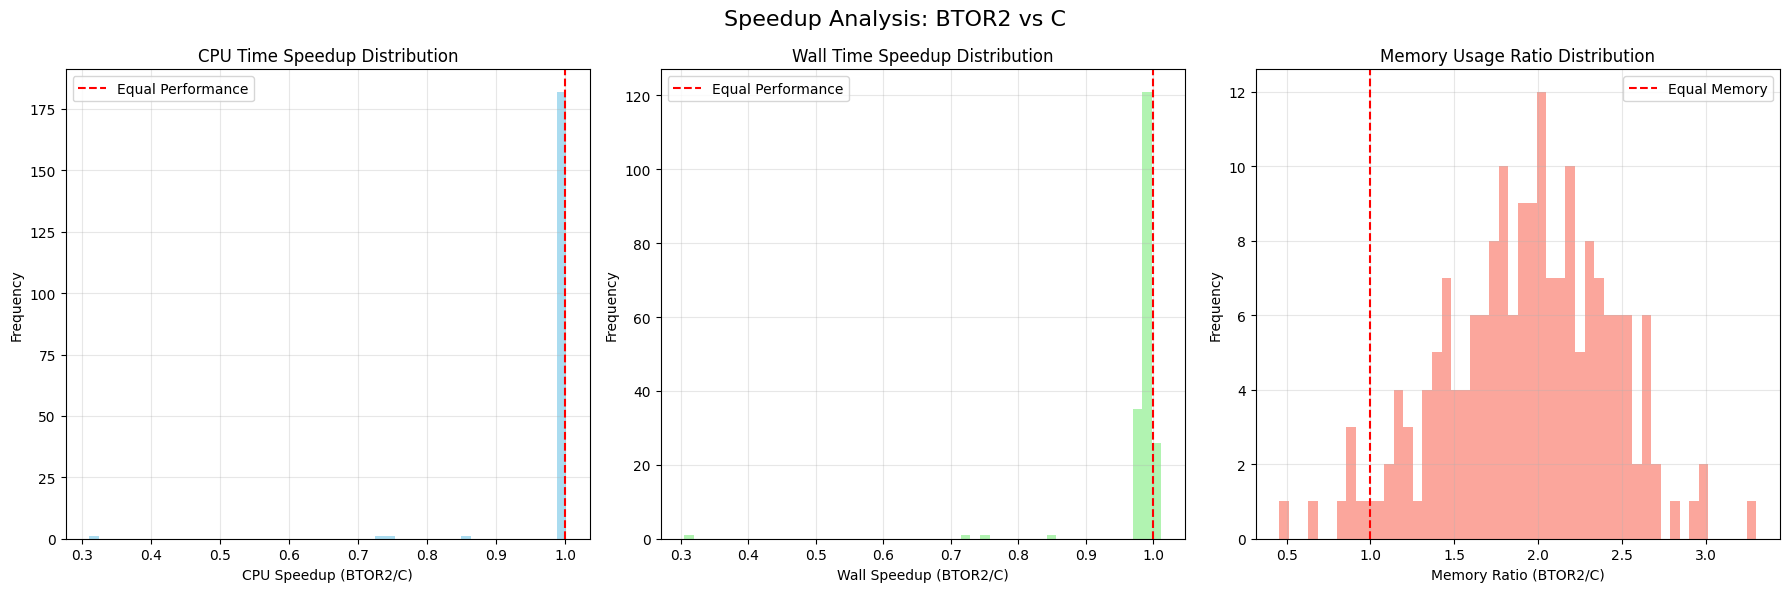


Speedup Analysis Summary:
Average CPU Speedup: 0.99
Average Wall Speedup: 0.98
Average Memory Ratio: 1.93


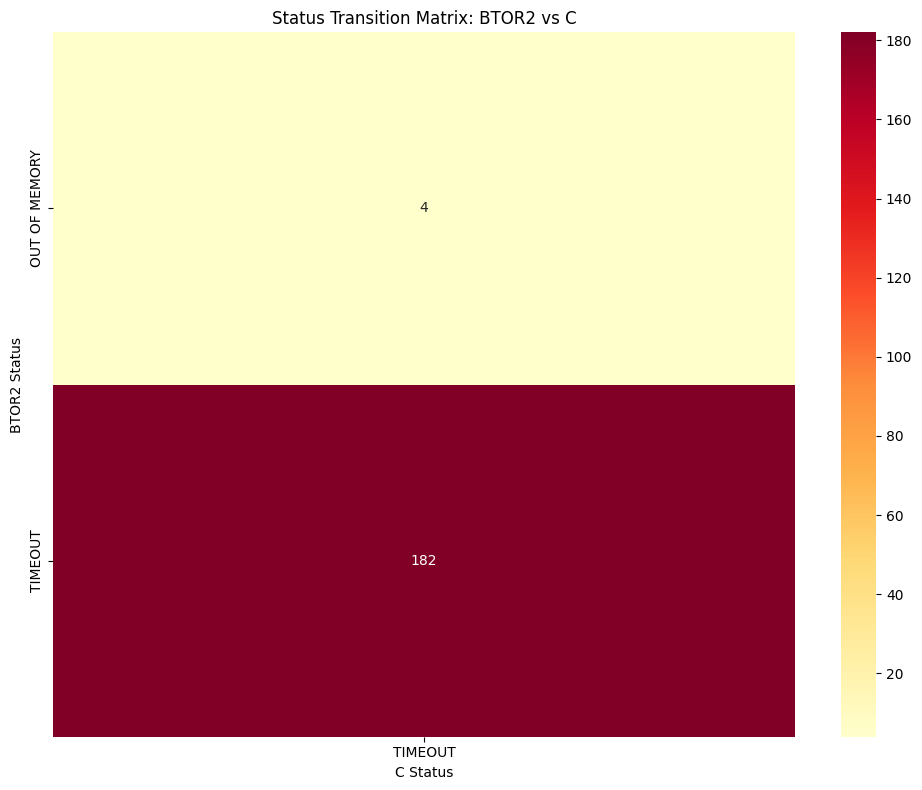

BENCHMARK COMPARISON SUMMARY REPORT

Total Benchmarks Compared: 186

Status Distribution:
BTOR2:
status_btor2
TIMEOUT          182
OUT OF MEMORY      4
Name: count, dtype: int64

C:
status_c
TIMEOUT    186
Name: count, dtype: int64

Performance Metrics (Average):
CPUTIME: BTOR2=984.02, C=990.79, Ratio=0.99
WALLTIME: BTOR2=954.30, C=970.76, Ratio=0.98
MEMORY: BTOR2=9289043043.10, C=4918385300.65, Ratio=1.89

Success Rates:
BTOR2: 2.2%
C: 0.0%

Detailed comparison saved to 'detailed_comparison.csv'

Analysis complete! Check the generated PNG files for visualizations.


In [11]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import os

class BenchmarkComparator:
    def __init__(self):
        self.df_btor2 = None
        self.df_c = None
        self.comparison_df = None
        
    def parse_xml_file(self, file_path, input_type):
        """Parse XML file and extract benchmark results"""
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        data = []
        for run in root.findall('run'):
            # Extract benchmark name and properties
            run_name = run.get('name', '')
            properties = run.get('properties', '')
            expected_verdict = run.get('expectedVerdict', '')
            
            # Extract column values
            columns = {}
            for col in run.findall('column'):
                title = col.get('title')
                value = col.get('value')
                columns[title] = value
            
            # Extract file information
            files_elem = run.get('files', '[]')
            
            row_data = {
                'input_type': input_type,
                'run_name': run_name,
                'properties': properties,
                'expected_verdict': expected_verdict,
                'status': columns.get('status', ''),
                'cputime': float(columns.get('cputime', '0').replace('s', '')) if columns.get('cputime') else 0,
                'walltime': float(columns.get('walltime', '0').replace('s', '')) if columns.get('walltime') else 0,
                'memory': int(columns.get('memory', '0').replace('B', '')) if columns.get('memory') else 0,
                'host': columns.get('host', ''),
                'files': files_elem
            }
            
            data.append(row_data)
        
        return pd.DataFrame(data)
    
    def load_data(self, btor2_file, c_file):
        """Load both XML files"""
        self.df_btor2 = self.parse_xml_file(btor2_file, 'btor2')
        self.df_c = self.parse_xml_file(c_file, 'c')
        
        print(f"Loaded {len(self.df_btor2)} BTOR2 benchmarks")
        print(f"Loaded {len(self.df_c)} C benchmarks")
    
    def create_comparison_dataframe(self):
        """Create a combined dataframe for comparison"""
        # Extract benchmark identifiers for matching
        def extract_benchmark_id(run_name):
            # Extract the core benchmark name (e.g., "adding.1.prop1" from the full path)
            parts = run_name.split('/')
            for part in parts:
                if any(x in part for x in ['adding', 'anderson', 'at', 'bakery', 'blocks', 'bridge', 'brp']):
                    return part.replace('.yml', '')
            return run_name
        
        # Add benchmark IDs
        self.df_btor2['benchmark_id'] = self.df_btor2['run_name'].apply(extract_benchmark_id)
        self.df_c['benchmark_id'] = self.df_c['run_name'].apply(extract_benchmark_id)
        
        # Merge dataframes on benchmark_id
        merged = pd.merge(
            self.df_btor2, 
            self.df_c, 
            on='benchmark_id', 
            suffixes=('_btor2', '_c'),
            how='inner'
        )
        
        self.comparison_df = merged
        print(f"Successfully matched {len(merged)} benchmarks")
        
        return merged
    
    def create_performance_comparison_plot(self):
        """Create performance comparison plots"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Performance Comparison: BTOR2 vs C Input Types', fontsize=16)
        
        # CPU Time Comparison
        axes[0, 0].scatter(self.comparison_df['cputime_btor2'], 
                          self.comparison_df['cputime_c'], alpha=0.6)
        axes[0, 0].plot([0, 1000], [0, 1000], 'r--', alpha=0.8)
        axes[0, 0].set_xlabel('BTOR2 CPU Time (s)')
        axes[0, 0].set_ylabel('C CPU Time (s)')
        axes[0, 0].set_title('CPU Time Comparison')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Wall Time Comparison
        axes[0, 1].scatter(self.comparison_df['walltime_btor2'], 
                          self.comparison_df['walltime_c'], alpha=0.6)
        axes[0, 1].plot([0, 1000], [0, 1000], 'r--', alpha=0.8)
        axes[0, 1].set_xlabel('BTOR2 Wall Time (s)')
        axes[0, 1].set_ylabel('C Wall Time (s)')
        axes[0, 1].set_title('Wall Time Comparison')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Memory Usage Comparison
        axes[1, 0].scatter(self.comparison_df['memory_btor2']/1e9, 
                          self.comparison_df['memory_c']/1e9, alpha=0.6)
        axes[1, 0].plot([0, 15], [0, 15], 'r--', alpha=0.8)
        axes[1, 0].set_xlabel('BTOR2 Memory (GB)')
        axes[1, 0].set_ylabel('C Memory (GB)')
        axes[1, 0].set_title('Memory Usage Comparison')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Status Distribution
        status_counts = pd.DataFrame({
            'BTOR2': self.comparison_df['status_btor2'].value_counts(),
            'C': self.comparison_df['status_c'].value_counts()
        }).fillna(0)
        
        status_counts.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Status Distribution Comparison')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_speedup_analysis(self):
        """Analyze speedup factors"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        # Calculate speedup factors
        self.comparison_df['cpu_speedup'] = self.comparison_df['cputime_btor2'] / self.comparison_df['cputime_c']
        self.comparison_df['wall_speedup'] = self.comparison_df['walltime_btor2'] / self.comparison_df['walltime_c']
        self.comparison_df['memory_ratio'] = self.comparison_df['memory_btor2'] / self.comparison_df['memory_c']
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Speedup Analysis: BTOR2 vs C', fontsize=16)
        
        # CPU Speedup distribution
        axes[0].hist(self.comparison_df['cpu_speedup'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='skyblue')
        axes[0].axvline(1, color='red', linestyle='--', label='Equal Performance')
        axes[0].set_xlabel('CPU Speedup (BTOR2/C)')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('CPU Time Speedup Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Wall Speedup distribution
        axes[1].hist(self.comparison_df['wall_speedup'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='lightgreen')
        axes[1].axvline(1, color='red', linestyle='--', label='Equal Performance')
        axes[1].set_xlabel('Wall Speedup (BTOR2/C)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Wall Time Speedup Distribution')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Memory ratio distribution
        axes[2].hist(self.comparison_df['memory_ratio'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='salmon')
        axes[2].axvline(1, color='red', linestyle='--', label='Equal Memory')
        axes[2].set_xlabel('Memory Ratio (BTOR2/C)')
        axes[2].set_ylabel('Frequency')
        axes[2].set_title('Memory Usage Ratio Distribution')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('speedup_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print summary statistics
        print("\nSpeedup Analysis Summary:")
        print(f"Average CPU Speedup: {self.comparison_df['cpu_speedup'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
        print(f"Average Wall Speedup: {self.comparison_df['wall_speedup'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
        print(f"Average Memory Ratio: {self.comparison_df['memory_ratio'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
    
    def create_status_comparison_matrix(self):
        """Create a matrix showing status transitions between input types"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        status_matrix = pd.crosstab(
            self.comparison_df['status_btor2'], 
            self.comparison_df['status_c'],
            margins=True
        )
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(status_matrix.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlOrRd')
        plt.title('Status Transition Matrix: BTOR2 vs C')
        plt.xlabel('C Status')
        plt.ylabel('BTOR2 Status')
        plt.tight_layout()
        plt.savefig('status_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return status_matrix
    
    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        print("="*60)
        print("BENCHMARK COMPARISON SUMMARY REPORT")
        print("="*60)
        
        # Basic statistics
        print(f"\nTotal Benchmarks Compared: {len(self.comparison_df)}")
        
        # Status summary
        print("\nStatus Distribution:")
        print("BTOR2:")
        print(self.comparison_df['status_btor2'].value_counts())
        print("\nC:")
        print(self.comparison_df['status_c'].value_counts())
        
        # Performance metrics
        print("\nPerformance Metrics (Average):")
        metrics = ['cputime', 'walltime', 'memory']
        for metric in metrics:
            btor2_avg = self.comparison_df[f'{metric}_btor2'].mean()
            c_avg = self.comparison_df[f'{metric}_c'].mean()
            ratio = btor2_avg / c_avg if c_avg > 0 else float('inf')
            print(f"{metric.upper()}: BTOR2={btor2_avg:.2f}, C={c_avg:.2f}, Ratio={ratio:.2f}")
        
        # Success rate comparison
        btor2_success = len(self.comparison_df[self.comparison_df['status_btor2'] != 'TIMEOUT'])
        c_success = len(self.comparison_df[self.comparison_df['status_c'] != 'TIMEOUT'])
        
        print(f"\nSuccess Rates:")
        print(f"BTOR2: {btor2_success/len(self.comparison_df)*100:.1f}%")
        print(f"C: {c_success/len(self.comparison_df)*100:.1f}%")
        
        # Save detailed comparison to CSV
        self.comparison_df.to_csv('detailed_comparison.csv', index=False)
        print(f"\nDetailed comparison saved to 'detailed_comparison.csv'")

# Example usage
def main():
    # Initialize comparator
    comparator = BenchmarkComparator()
    
    # Load your XML files (replace with actual file paths)
    btor2_file = "result_xmls\\theta_algos.2025-10-29_06-24-29.results.btor2-imc.btor2.xml"
    c_file = "result_xmls\\theta_algos.2025-10-29_06-24-29.results.c-bit-imc.c-bit.xml"  # Your C input type file
    
    try:
        # Load data
        comparator.load_data(btor2_file, c_file)
        
        # Generate all analyses
        comparator.create_comparison_dataframe()
        comparator.create_performance_comparison_plot()
        comparator.create_speedup_analysis()
        status_matrix = comparator.create_status_comparison_matrix()
        comparator.generate_summary_report()
        
        print("\nAnalysis complete! Check the generated PNG files for visualizations.")
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please make sure both XML files are in the correct path.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## K-Induction

Loaded 693 BTOR2 benchmarks
Loaded 693 C benchmarks
Successfully matched 186 benchmarks


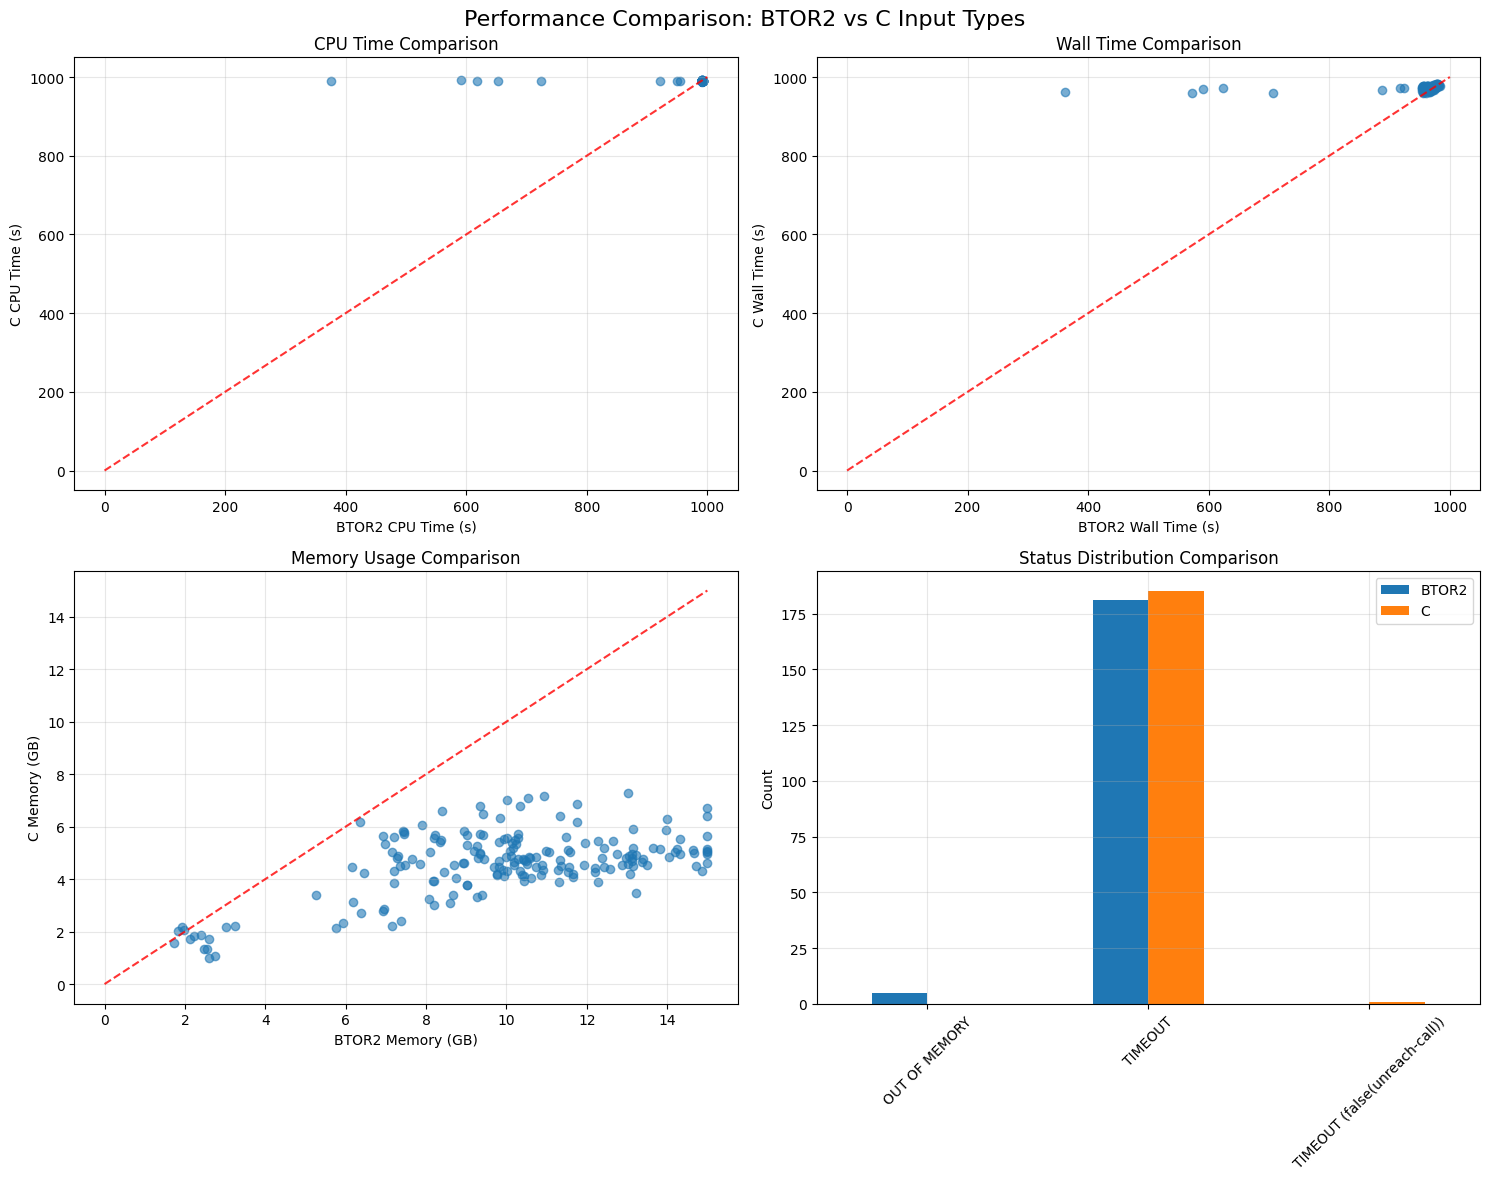

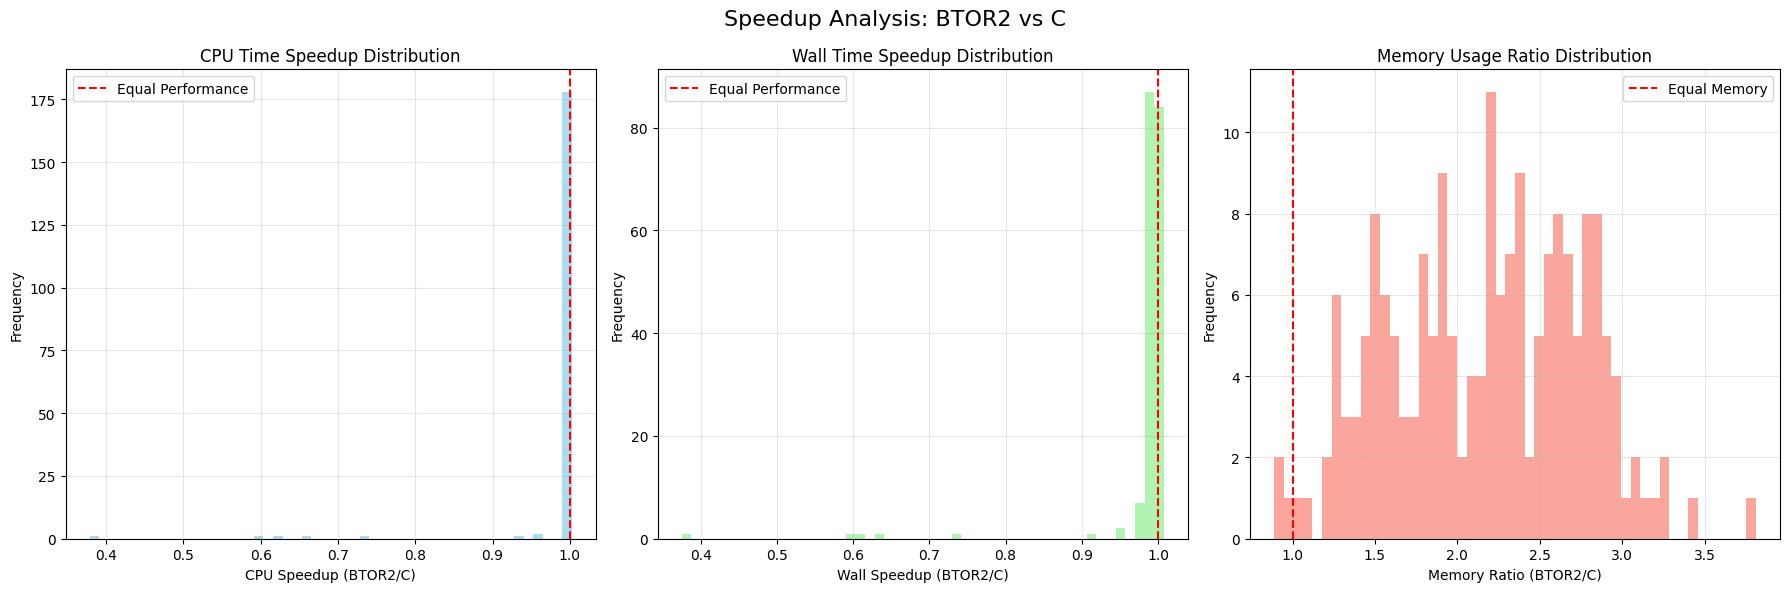


Speedup Analysis Summary:
Average CPU Speedup: 0.99
Average Wall Speedup: 0.98
Average Memory Ratio: 2.18


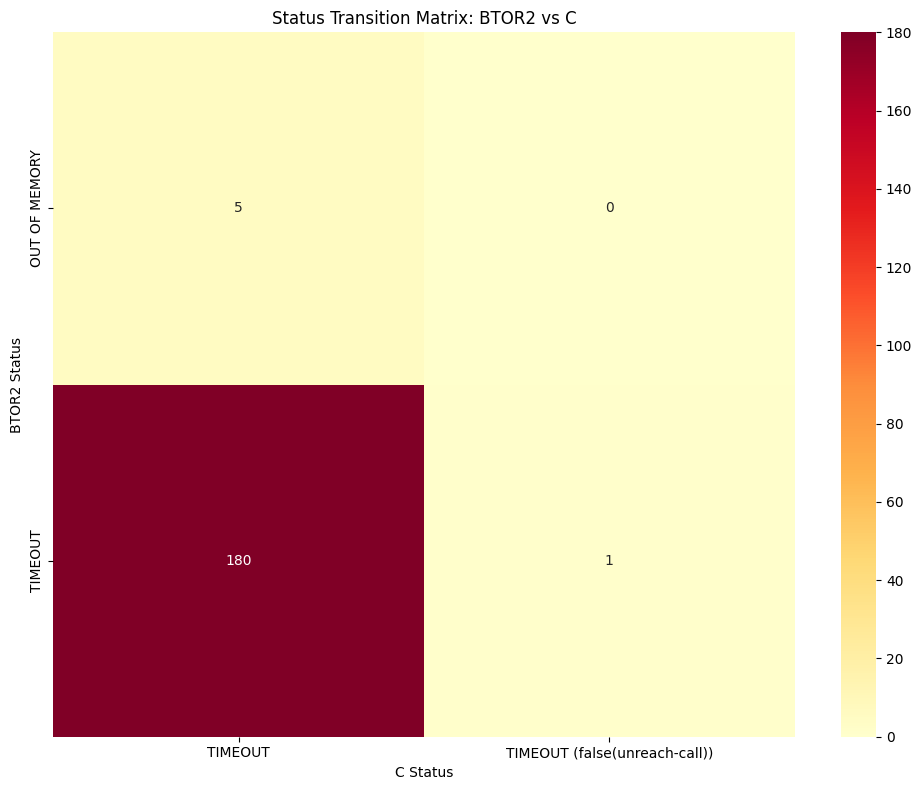

BENCHMARK COMPARISON SUMMARY REPORT

Total Benchmarks Compared: 186

Status Distribution:
BTOR2:
status_btor2
TIMEOUT          181
OUT OF MEMORY      5
Name: count, dtype: int64

C:
status_c
TIMEOUT                          185
TIMEOUT (false(unreach-call))      1
Name: count, dtype: int64

Performance Metrics (Average):
CPUTIME: BTOR2=979.64, C=990.73, Ratio=0.99
WALLTIME: BTOR2=954.69, C=972.00, Ratio=0.98
MEMORY: BTOR2=9895955731.27, C=4595372032.00, Ratio=2.15

Success Rates:
BTOR2: 2.7%
C: 0.5%

Detailed comparison saved to 'detailed_comparison.csv'

Analysis complete! Check the generated PNG files for visualizations.


In [12]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import os

class BenchmarkComparator:
    def __init__(self):
        self.df_btor2 = None
        self.df_c = None
        self.comparison_df = None
        
    def parse_xml_file(self, file_path, input_type):
        """Parse XML file and extract benchmark results"""
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        data = []
        for run in root.findall('run'):
            # Extract benchmark name and properties
            run_name = run.get('name', '')
            properties = run.get('properties', '')
            expected_verdict = run.get('expectedVerdict', '')
            
            # Extract column values
            columns = {}
            for col in run.findall('column'):
                title = col.get('title')
                value = col.get('value')
                columns[title] = value
            
            # Extract file information
            files_elem = run.get('files', '[]')
            
            row_data = {
                'input_type': input_type,
                'run_name': run_name,
                'properties': properties,
                'expected_verdict': expected_verdict,
                'status': columns.get('status', ''),
                'cputime': float(columns.get('cputime', '0').replace('s', '')) if columns.get('cputime') else 0,
                'walltime': float(columns.get('walltime', '0').replace('s', '')) if columns.get('walltime') else 0,
                'memory': int(columns.get('memory', '0').replace('B', '')) if columns.get('memory') else 0,
                'host': columns.get('host', ''),
                'files': files_elem
            }
            
            data.append(row_data)
        
        return pd.DataFrame(data)
    
    def load_data(self, btor2_file, c_file):
        """Load both XML files"""
        self.df_btor2 = self.parse_xml_file(btor2_file, 'btor2')
        self.df_c = self.parse_xml_file(c_file, 'c')
        
        print(f"Loaded {len(self.df_btor2)} BTOR2 benchmarks")
        print(f"Loaded {len(self.df_c)} C benchmarks")
    
    def create_comparison_dataframe(self):
        """Create a combined dataframe for comparison"""
        # Extract benchmark identifiers for matching
        def extract_benchmark_id(run_name):
            # Extract the core benchmark name (e.g., "adding.1.prop1" from the full path)
            parts = run_name.split('/')
            for part in parts:
                if any(x in part for x in ['adding', 'anderson', 'at', 'bakery', 'blocks', 'bridge', 'brp']):
                    return part.replace('.yml', '')
            return run_name
        
        # Add benchmark IDs
        self.df_btor2['benchmark_id'] = self.df_btor2['run_name'].apply(extract_benchmark_id)
        self.df_c['benchmark_id'] = self.df_c['run_name'].apply(extract_benchmark_id)
        
        # Merge dataframes on benchmark_id
        merged = pd.merge(
            self.df_btor2, 
            self.df_c, 
            on='benchmark_id', 
            suffixes=('_btor2', '_c'),
            how='inner'
        )
        
        self.comparison_df = merged
        print(f"Successfully matched {len(merged)} benchmarks")
        
        return merged
    
    def create_performance_comparison_plot(self):
        """Create performance comparison plots"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Performance Comparison: BTOR2 vs C Input Types', fontsize=16)
        
        # CPU Time Comparison
        axes[0, 0].scatter(self.comparison_df['cputime_btor2'], 
                          self.comparison_df['cputime_c'], alpha=0.6)
        axes[0, 0].plot([0, 1000], [0, 1000], 'r--', alpha=0.8)
        axes[0, 0].set_xlabel('BTOR2 CPU Time (s)')
        axes[0, 0].set_ylabel('C CPU Time (s)')
        axes[0, 0].set_title('CPU Time Comparison')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Wall Time Comparison
        axes[0, 1].scatter(self.comparison_df['walltime_btor2'], 
                          self.comparison_df['walltime_c'], alpha=0.6)
        axes[0, 1].plot([0, 1000], [0, 1000], 'r--', alpha=0.8)
        axes[0, 1].set_xlabel('BTOR2 Wall Time (s)')
        axes[0, 1].set_ylabel('C Wall Time (s)')
        axes[0, 1].set_title('Wall Time Comparison')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Memory Usage Comparison
        axes[1, 0].scatter(self.comparison_df['memory_btor2']/1e9, 
                          self.comparison_df['memory_c']/1e9, alpha=0.6)
        axes[1, 0].plot([0, 15], [0, 15], 'r--', alpha=0.8)
        axes[1, 0].set_xlabel('BTOR2 Memory (GB)')
        axes[1, 0].set_ylabel('C Memory (GB)')
        axes[1, 0].set_title('Memory Usage Comparison')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Status Distribution
        status_counts = pd.DataFrame({
            'BTOR2': self.comparison_df['status_btor2'].value_counts(),
            'C': self.comparison_df['status_c'].value_counts()
        }).fillna(0)
        
        status_counts.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Status Distribution Comparison')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_speedup_analysis(self):
        """Analyze speedup factors"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        # Calculate speedup factors
        self.comparison_df['cpu_speedup'] = self.comparison_df['cputime_btor2'] / self.comparison_df['cputime_c']
        self.comparison_df['wall_speedup'] = self.comparison_df['walltime_btor2'] / self.comparison_df['walltime_c']
        self.comparison_df['memory_ratio'] = self.comparison_df['memory_btor2'] / self.comparison_df['memory_c']
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Speedup Analysis: BTOR2 vs C', fontsize=16)
        
        # CPU Speedup distribution
        axes[0].hist(self.comparison_df['cpu_speedup'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='skyblue')
        axes[0].axvline(1, color='red', linestyle='--', label='Equal Performance')
        axes[0].set_xlabel('CPU Speedup (BTOR2/C)')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('CPU Time Speedup Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Wall Speedup distribution
        axes[1].hist(self.comparison_df['wall_speedup'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='lightgreen')
        axes[1].axvline(1, color='red', linestyle='--', label='Equal Performance')
        axes[1].set_xlabel('Wall Speedup (BTOR2/C)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Wall Time Speedup Distribution')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Memory ratio distribution
        axes[2].hist(self.comparison_df['memory_ratio'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='salmon')
        axes[2].axvline(1, color='red', linestyle='--', label='Equal Memory')
        axes[2].set_xlabel('Memory Ratio (BTOR2/C)')
        axes[2].set_ylabel('Frequency')
        axes[2].set_title('Memory Usage Ratio Distribution')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('speedup_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print summary statistics
        print("\nSpeedup Analysis Summary:")
        print(f"Average CPU Speedup: {self.comparison_df['cpu_speedup'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
        print(f"Average Wall Speedup: {self.comparison_df['wall_speedup'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
        print(f"Average Memory Ratio: {self.comparison_df['memory_ratio'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
    
    def create_status_comparison_matrix(self):
        """Create a matrix showing status transitions between input types"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        status_matrix = pd.crosstab(
            self.comparison_df['status_btor2'], 
            self.comparison_df['status_c'],
            margins=True
        )
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(status_matrix.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlOrRd')
        plt.title('Status Transition Matrix: BTOR2 vs C')
        plt.xlabel('C Status')
        plt.ylabel('BTOR2 Status')
        plt.tight_layout()
        plt.savefig('status_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return status_matrix
    
    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        print("="*60)
        print("BENCHMARK COMPARISON SUMMARY REPORT")
        print("="*60)
        
        # Basic statistics
        print(f"\nTotal Benchmarks Compared: {len(self.comparison_df)}")
        
        # Status summary
        print("\nStatus Distribution:")
        print("BTOR2:")
        print(self.comparison_df['status_btor2'].value_counts())
        print("\nC:")
        print(self.comparison_df['status_c'].value_counts())
        
        # Performance metrics
        print("\nPerformance Metrics (Average):")
        metrics = ['cputime', 'walltime', 'memory']
        for metric in metrics:
            btor2_avg = self.comparison_df[f'{metric}_btor2'].mean()
            c_avg = self.comparison_df[f'{metric}_c'].mean()
            ratio = btor2_avg / c_avg if c_avg > 0 else float('inf')
            print(f"{metric.upper()}: BTOR2={btor2_avg:.2f}, C={c_avg:.2f}, Ratio={ratio:.2f}")
        
        # Success rate comparison
        btor2_success = len(self.comparison_df[self.comparison_df['status_btor2'] != 'TIMEOUT'])
        c_success = len(self.comparison_df[self.comparison_df['status_c'] != 'TIMEOUT'])
        
        print(f"\nSuccess Rates:")
        print(f"BTOR2: {btor2_success/len(self.comparison_df)*100:.1f}%")
        print(f"C: {c_success/len(self.comparison_df)*100:.1f}%")
        
        # Save detailed comparison to CSV
        self.comparison_df.to_csv('detailed_comparison.csv', index=False)
        print(f"\nDetailed comparison saved to 'detailed_comparison.csv'")

# Example usage
def main():
    # Initialize comparator
    comparator = BenchmarkComparator()
    
    # Load your XML files (replace with actual file paths)
    btor2_file = "result_xmls\\theta_algos.2025-10-29_06-24-29.results.btor2-kind.btor2.xml"
    c_file = "result_xmls\\theta_algos.2025-10-29_06-24-29.results.c-bit-kind.c-bit.xml"  # Your C input type file
    
    try:
        # Load data
        comparator.load_data(btor2_file, c_file)
        
        # Generate all analyses
        comparator.create_comparison_dataframe()
        comparator.create_performance_comparison_plot()
        comparator.create_speedup_analysis()
        status_matrix = comparator.create_status_comparison_matrix()
        comparator.generate_summary_report()
        
        print("\nAnalysis complete! Check the generated PNG files for visualizations.")
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please make sure both XML files are in the correct path.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

## CEGAR w predicative abstraction

Loaded 693 BTOR2 benchmarks
Loaded 693 C benchmarks
Successfully matched 186 benchmarks


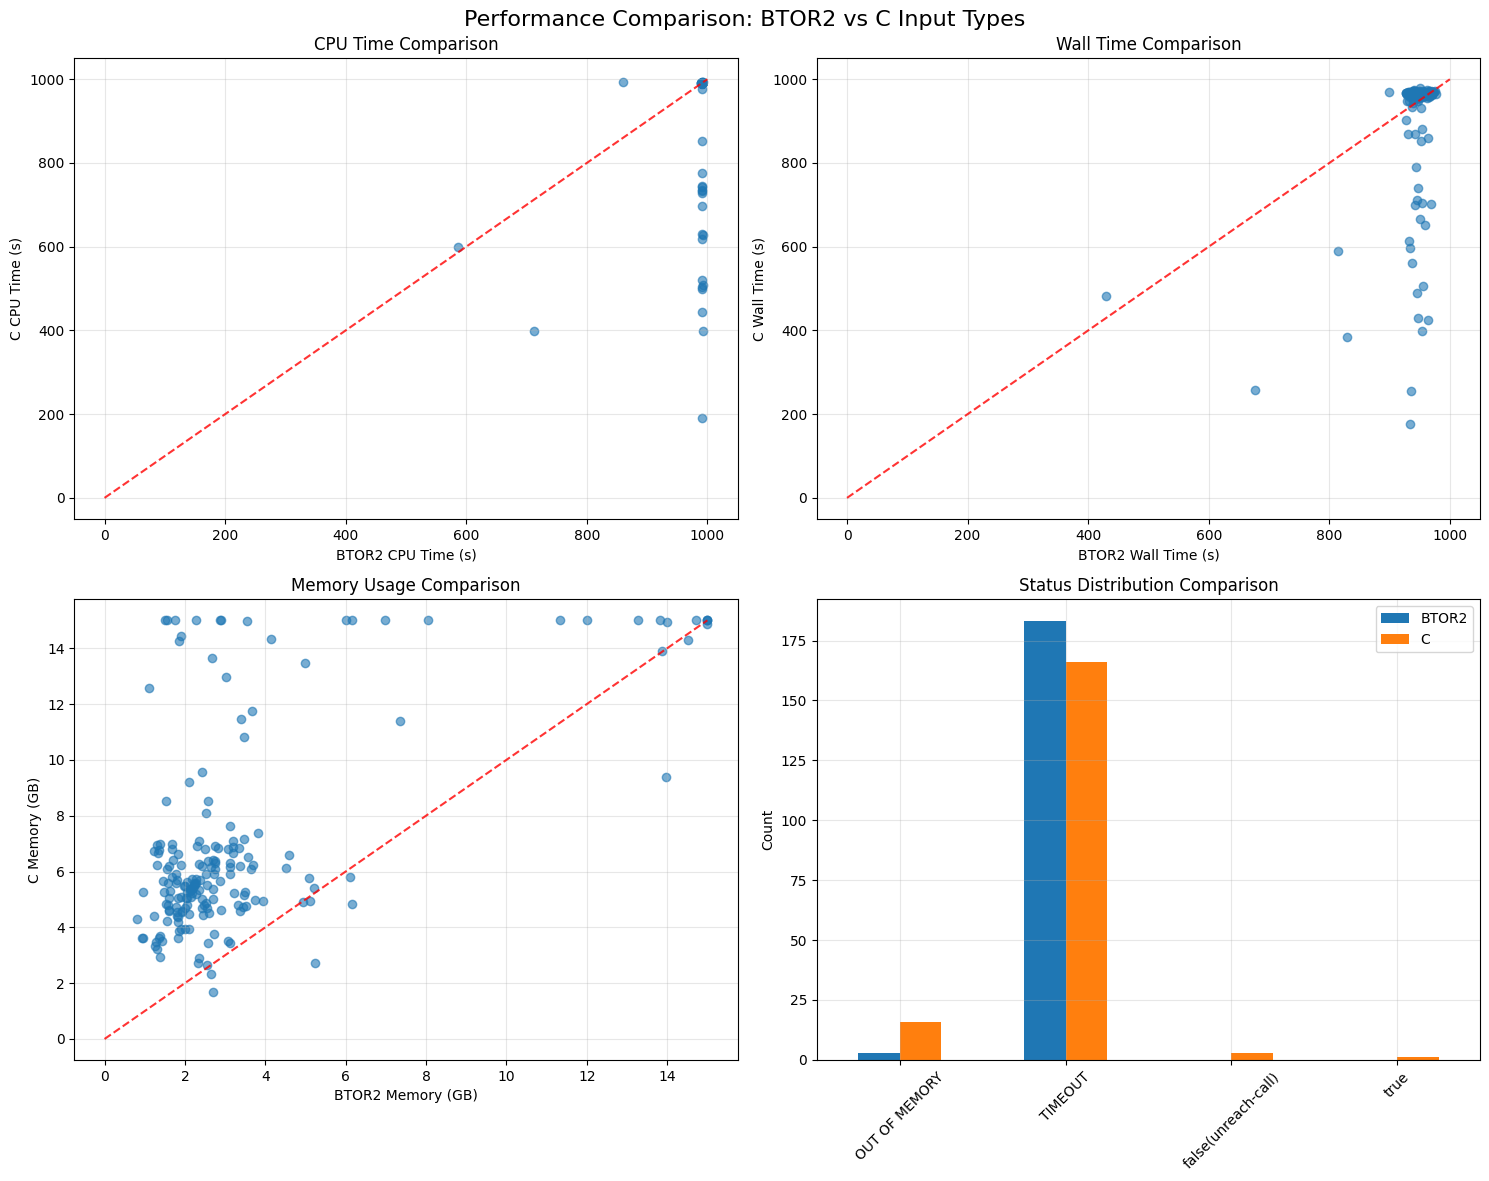

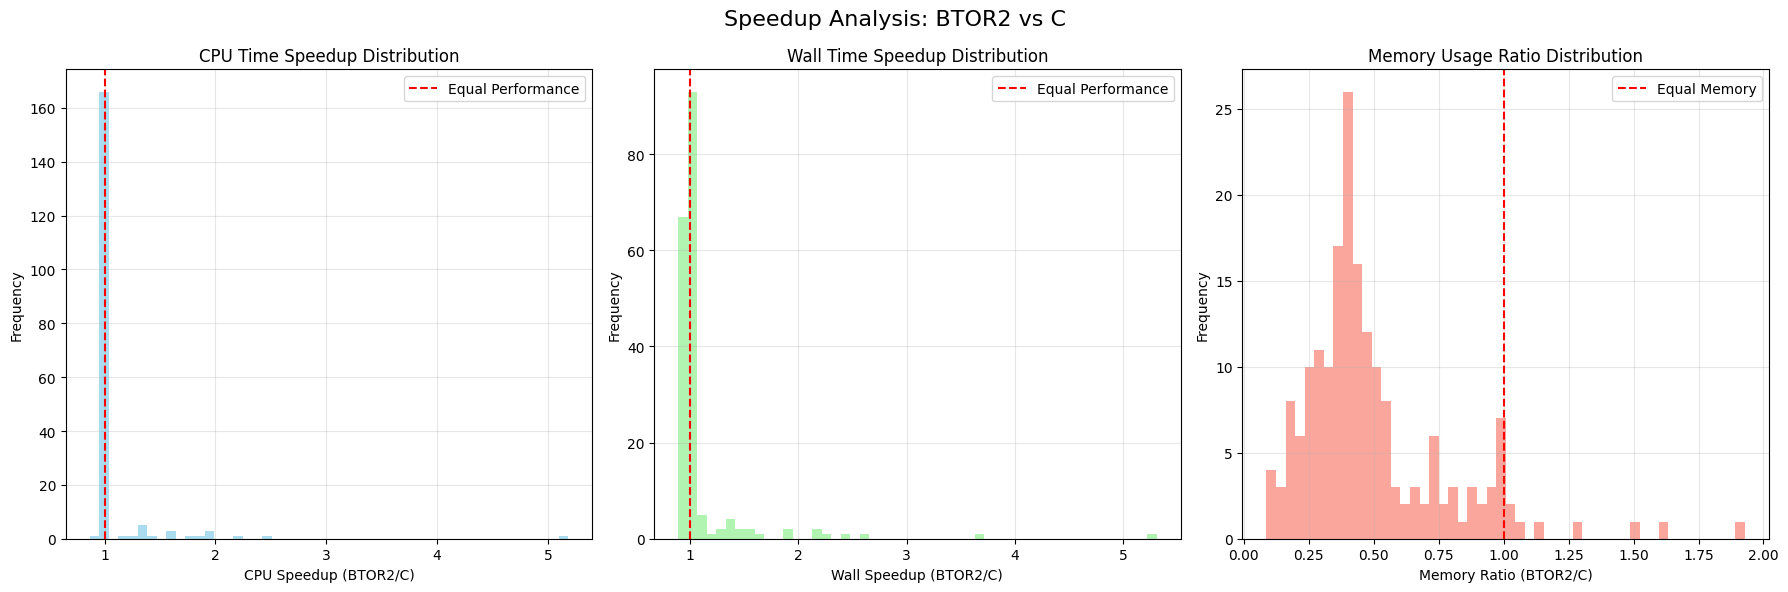


Speedup Analysis Summary:
Average CPU Speedup: 1.08
Average Wall Speedup: 1.10
Average Memory Ratio: 0.49


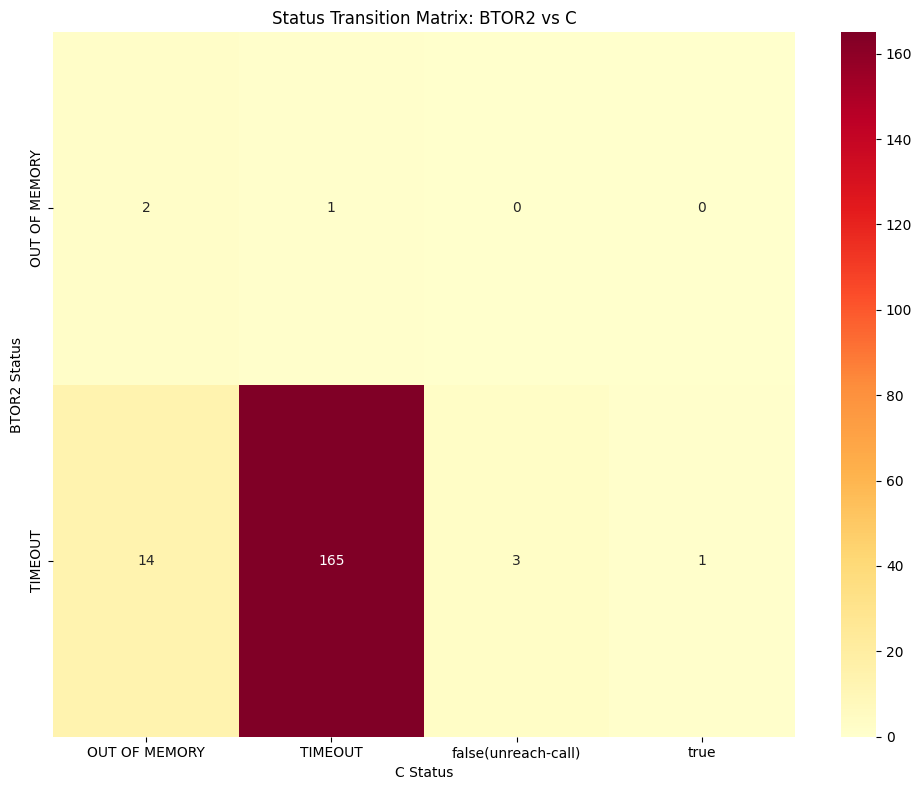

BENCHMARK COMPARISON SUMMARY REPORT

Total Benchmarks Compared: 186

Status Distribution:
BTOR2:
status_btor2
TIMEOUT          183
OUT OF MEMORY      3
Name: count, dtype: int64

C:
status_c
TIMEOUT                166
OUT OF MEMORY           16
false(unreach-call)      3
true                     1
Name: count, dtype: int64

Performance Metrics (Average):
CPUTIME: BTOR2=986.44, C=948.62, Ratio=1.04
WALLTIME: BTOR2=943.38, C=911.64, Ratio=1.03
MEMORY: BTOR2=3393676409.12, C=7006440877.42, Ratio=0.48

Success Rates:
BTOR2: 1.6%
C: 10.8%

Detailed comparison saved to 'detailed_comparison.csv'

Analysis complete! Check the generated PNG files for visualizations.


In [13]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import os

class BenchmarkComparator:
    def __init__(self):
        self.df_btor2 = None
        self.df_c = None
        self.comparison_df = None
        
    def parse_xml_file(self, file_path, input_type):
        """Parse XML file and extract benchmark results"""
        tree = ET.parse(file_path)
        root = tree.getroot()
        
        data = []
        for run in root.findall('run'):
            # Extract benchmark name and properties
            run_name = run.get('name', '')
            properties = run.get('properties', '')
            expected_verdict = run.get('expectedVerdict', '')
            
            # Extract column values
            columns = {}
            for col in run.findall('column'):
                title = col.get('title')
                value = col.get('value')
                columns[title] = value
            
            # Extract file information
            files_elem = run.get('files', '[]')
            
            row_data = {
                'input_type': input_type,
                'run_name': run_name,
                'properties': properties,
                'expected_verdict': expected_verdict,
                'status': columns.get('status', ''),
                'cputime': float(columns.get('cputime', '0').replace('s', '')) if columns.get('cputime') else 0,
                'walltime': float(columns.get('walltime', '0').replace('s', '')) if columns.get('walltime') else 0,
                'memory': int(columns.get('memory', '0').replace('B', '')) if columns.get('memory') else 0,
                'host': columns.get('host', ''),
                'files': files_elem
            }
            
            data.append(row_data)
        
        return pd.DataFrame(data)
    
    def load_data(self, btor2_file, c_file):
        """Load both XML files"""
        self.df_btor2 = self.parse_xml_file(btor2_file, 'btor2')
        self.df_c = self.parse_xml_file(c_file, 'c')
        
        print(f"Loaded {len(self.df_btor2)} BTOR2 benchmarks")
        print(f"Loaded {len(self.df_c)} C benchmarks")
    
    def create_comparison_dataframe(self):
        """Create a combined dataframe for comparison"""
        # Extract benchmark identifiers for matching
        def extract_benchmark_id(run_name):
            # Extract the core benchmark name (e.g., "adding.1.prop1" from the full path)
            parts = run_name.split('/')
            for part in parts:
                if any(x in part for x in ['adding', 'anderson', 'at', 'bakery', 'blocks', 'bridge', 'brp']):
                    return part.replace('.yml', '')
            return run_name
        
        # Add benchmark IDs
        self.df_btor2['benchmark_id'] = self.df_btor2['run_name'].apply(extract_benchmark_id)
        self.df_c['benchmark_id'] = self.df_c['run_name'].apply(extract_benchmark_id)
        
        # Merge dataframes on benchmark_id
        merged = pd.merge(
            self.df_btor2, 
            self.df_c, 
            on='benchmark_id', 
            suffixes=('_btor2', '_c'),
            how='inner'
        )
        
        self.comparison_df = merged
        print(f"Successfully matched {len(merged)} benchmarks")
        
        return merged
    
    def create_performance_comparison_plot(self):
        """Create performance comparison plots"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Performance Comparison: BTOR2 vs C Input Types', fontsize=16)
        
        # CPU Time Comparison
        axes[0, 0].scatter(self.comparison_df['cputime_btor2'], 
                          self.comparison_df['cputime_c'], alpha=0.6)
        axes[0, 0].plot([0, 1000], [0, 1000], 'r--', alpha=0.8)
        axes[0, 0].set_xlabel('BTOR2 CPU Time (s)')
        axes[0, 0].set_ylabel('C CPU Time (s)')
        axes[0, 0].set_title('CPU Time Comparison')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Wall Time Comparison
        axes[0, 1].scatter(self.comparison_df['walltime_btor2'], 
                          self.comparison_df['walltime_c'], alpha=0.6)
        axes[0, 1].plot([0, 1000], [0, 1000], 'r--', alpha=0.8)
        axes[0, 1].set_xlabel('BTOR2 Wall Time (s)')
        axes[0, 1].set_ylabel('C Wall Time (s)')
        axes[0, 1].set_title('Wall Time Comparison')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Memory Usage Comparison
        axes[1, 0].scatter(self.comparison_df['memory_btor2']/1e9, 
                          self.comparison_df['memory_c']/1e9, alpha=0.6)
        axes[1, 0].plot([0, 15], [0, 15], 'r--', alpha=0.8)
        axes[1, 0].set_xlabel('BTOR2 Memory (GB)')
        axes[1, 0].set_ylabel('C Memory (GB)')
        axes[1, 0].set_title('Memory Usage Comparison')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Status Distribution
        status_counts = pd.DataFrame({
            'BTOR2': self.comparison_df['status_btor2'].value_counts(),
            'C': self.comparison_df['status_c'].value_counts()
        }).fillna(0)
        
        status_counts.plot(kind='bar', ax=axes[1, 1])
        axes[1, 1].set_title('Status Distribution Comparison')
        axes[1, 1].set_ylabel('Count')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def create_speedup_analysis(self):
        """Analyze speedup factors"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        # Calculate speedup factors
        self.comparison_df['cpu_speedup'] = self.comparison_df['cputime_btor2'] / self.comparison_df['cputime_c']
        self.comparison_df['wall_speedup'] = self.comparison_df['walltime_btor2'] / self.comparison_df['walltime_c']
        self.comparison_df['memory_ratio'] = self.comparison_df['memory_btor2'] / self.comparison_df['memory_c']
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle('Speedup Analysis: BTOR2 vs C', fontsize=16)
        
        # CPU Speedup distribution
        axes[0].hist(self.comparison_df['cpu_speedup'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='skyblue')
        axes[0].axvline(1, color='red', linestyle='--', label='Equal Performance')
        axes[0].set_xlabel('CPU Speedup (BTOR2/C)')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('CPU Time Speedup Distribution')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Wall Speedup distribution
        axes[1].hist(self.comparison_df['wall_speedup'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='lightgreen')
        axes[1].axvline(1, color='red', linestyle='--', label='Equal Performance')
        axes[1].set_xlabel('Wall Speedup (BTOR2/C)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Wall Time Speedup Distribution')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        # Memory ratio distribution
        axes[2].hist(self.comparison_df['memory_ratio'].replace([np.inf, -np.inf], np.nan).dropna(), 
                    bins=50, alpha=0.7, color='salmon')
        axes[2].axvline(1, color='red', linestyle='--', label='Equal Memory')
        axes[2].set_xlabel('Memory Ratio (BTOR2/C)')
        axes[2].set_ylabel('Frequency')
        axes[2].set_title('Memory Usage Ratio Distribution')
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('speedup_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print summary statistics
        print("\nSpeedup Analysis Summary:")
        print(f"Average CPU Speedup: {self.comparison_df['cpu_speedup'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
        print(f"Average Wall Speedup: {self.comparison_df['wall_speedup'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
        print(f"Average Memory Ratio: {self.comparison_df['memory_ratio'].replace([np.inf, -np.inf], np.nan).mean():.2f}")
    
    def create_status_comparison_matrix(self):
        """Create a matrix showing status transitions between input types"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        status_matrix = pd.crosstab(
            self.comparison_df['status_btor2'], 
            self.comparison_df['status_c'],
            margins=True
        )
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(status_matrix.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlOrRd')
        plt.title('Status Transition Matrix: BTOR2 vs C')
        plt.xlabel('C Status')
        plt.ylabel('BTOR2 Status')
        plt.tight_layout()
        plt.savefig('status_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return status_matrix
    
    def generate_summary_report(self):
        """Generate a comprehensive summary report"""
        if self.comparison_df is None:
            self.create_comparison_dataframe()
        
        print("="*60)
        print("BENCHMARK COMPARISON SUMMARY REPORT")
        print("="*60)
        
        # Basic statistics
        print(f"\nTotal Benchmarks Compared: {len(self.comparison_df)}")
        
        # Status summary
        print("\nStatus Distribution:")
        print("BTOR2:")
        print(self.comparison_df['status_btor2'].value_counts())
        print("\nC:")
        print(self.comparison_df['status_c'].value_counts())
        
        # Performance metrics
        print("\nPerformance Metrics (Average):")
        metrics = ['cputime', 'walltime', 'memory']
        for metric in metrics:
            btor2_avg = self.comparison_df[f'{metric}_btor2'].mean()
            c_avg = self.comparison_df[f'{metric}_c'].mean()
            ratio = btor2_avg / c_avg if c_avg > 0 else float('inf')
            print(f"{metric.upper()}: BTOR2={btor2_avg:.2f}, C={c_avg:.2f}, Ratio={ratio:.2f}")
        
        # Success rate comparison
        btor2_success = len(self.comparison_df[self.comparison_df['status_btor2'] != 'TIMEOUT'])
        c_success = len(self.comparison_df[self.comparison_df['status_c'] != 'TIMEOUT'])
        
        print(f"\nSuccess Rates:")
        print(f"BTOR2: {btor2_success/len(self.comparison_df)*100:.1f}%")
        print(f"C: {c_success/len(self.comparison_df)*100:.1f}%")
        
        # Save detailed comparison to CSV
        self.comparison_df.to_csv('detailed_comparison.csv', index=False)
        print(f"\nDetailed comparison saved to 'detailed_comparison.csv'")

# Example usage
def main():
    # Initialize comparator
    comparator = BenchmarkComparator()
    
    # Load your XML files (replace with actual file paths)
    btor2_file = "result_xmls\\theta_algos.2025-10-29_06-24-29.results.btor2-pred-cegar.btor2-pred.xml"
    c_file = "result_xmls\\theta_algos.2025-10-29_06-24-29.results.c-bit-pred-cegar.c-bit-pred.xml"  # Your C input type file
    
    try:
        # Load data
        comparator.load_data(btor2_file, c_file)
        
        # Generate all analyses
        comparator.create_comparison_dataframe()
        comparator.create_performance_comparison_plot()
        comparator.create_speedup_analysis()
        status_matrix = comparator.create_status_comparison_matrix()
        comparator.generate_summary_report()
        
        print("\nAnalysis complete! Check the generated PNG files for visualizations.")
        
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please make sure both XML files are in the correct path.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

Starting comprehensive algorithm analysis...
Found 12 XML files
Processing: theta_algos.2025-10-29_06-24-29.results.btor2-bounded.btor2.xml -> BMC/BTOR2
  Loaded 693 runs, 4 successful
Processing: theta_algos.2025-10-29_06-24-29.results.btor2-expl-cegar.btor2-expl.xml -> CEGAR_EXPL/BTOR2
  Loaded 693 runs, 21 successful
Processing: theta_algos.2025-10-29_06-24-29.results.btor2-ic3.btor2.xml -> IC3/BTOR2
  Loaded 693 runs, 0 successful
Processing: theta_algos.2025-10-29_06-24-29.results.btor2-imc.btor2.xml -> IMC/BTOR2
  Loaded 693 runs, 3 successful
Processing: theta_algos.2025-10-29_06-24-29.results.btor2-kind.btor2.xml -> K-IND/BTOR2
  Loaded 693 runs, 4 successful
Processing: theta_algos.2025-10-29_06-24-29.results.btor2-pred-cegar.btor2-pred.xml -> CEGAR_PRED/BTOR2
  Loaded 693 runs, 25 successful
Processing: theta_algos.2025-10-29_06-24-29.results.c-bit-bounded.c-bit.xml -> BMC/C
  Loaded 693 runs, 25 successful
Processing: theta_algos.2025-10-29_06-24-29.results.c-bit-expl-cegar.

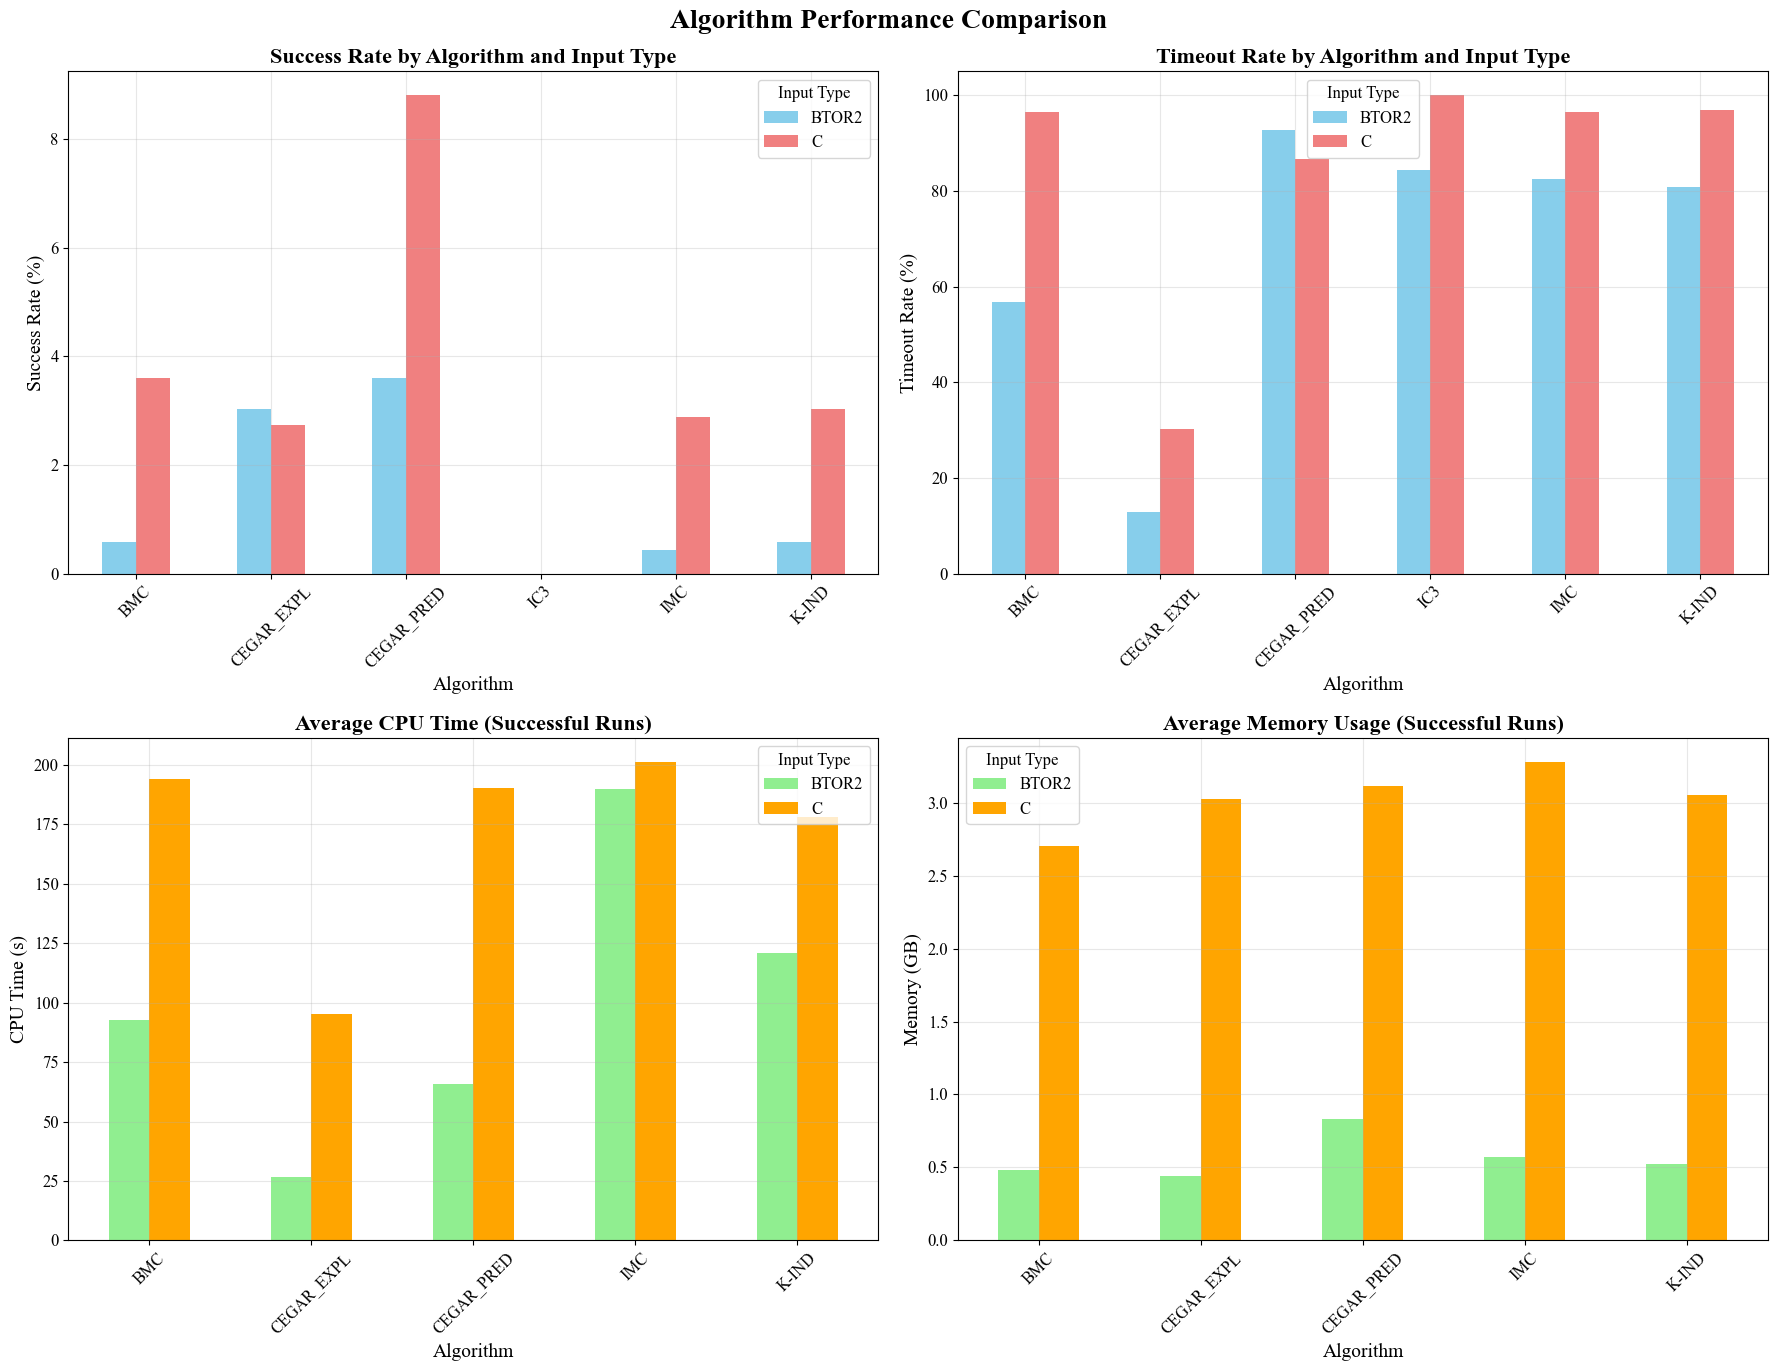

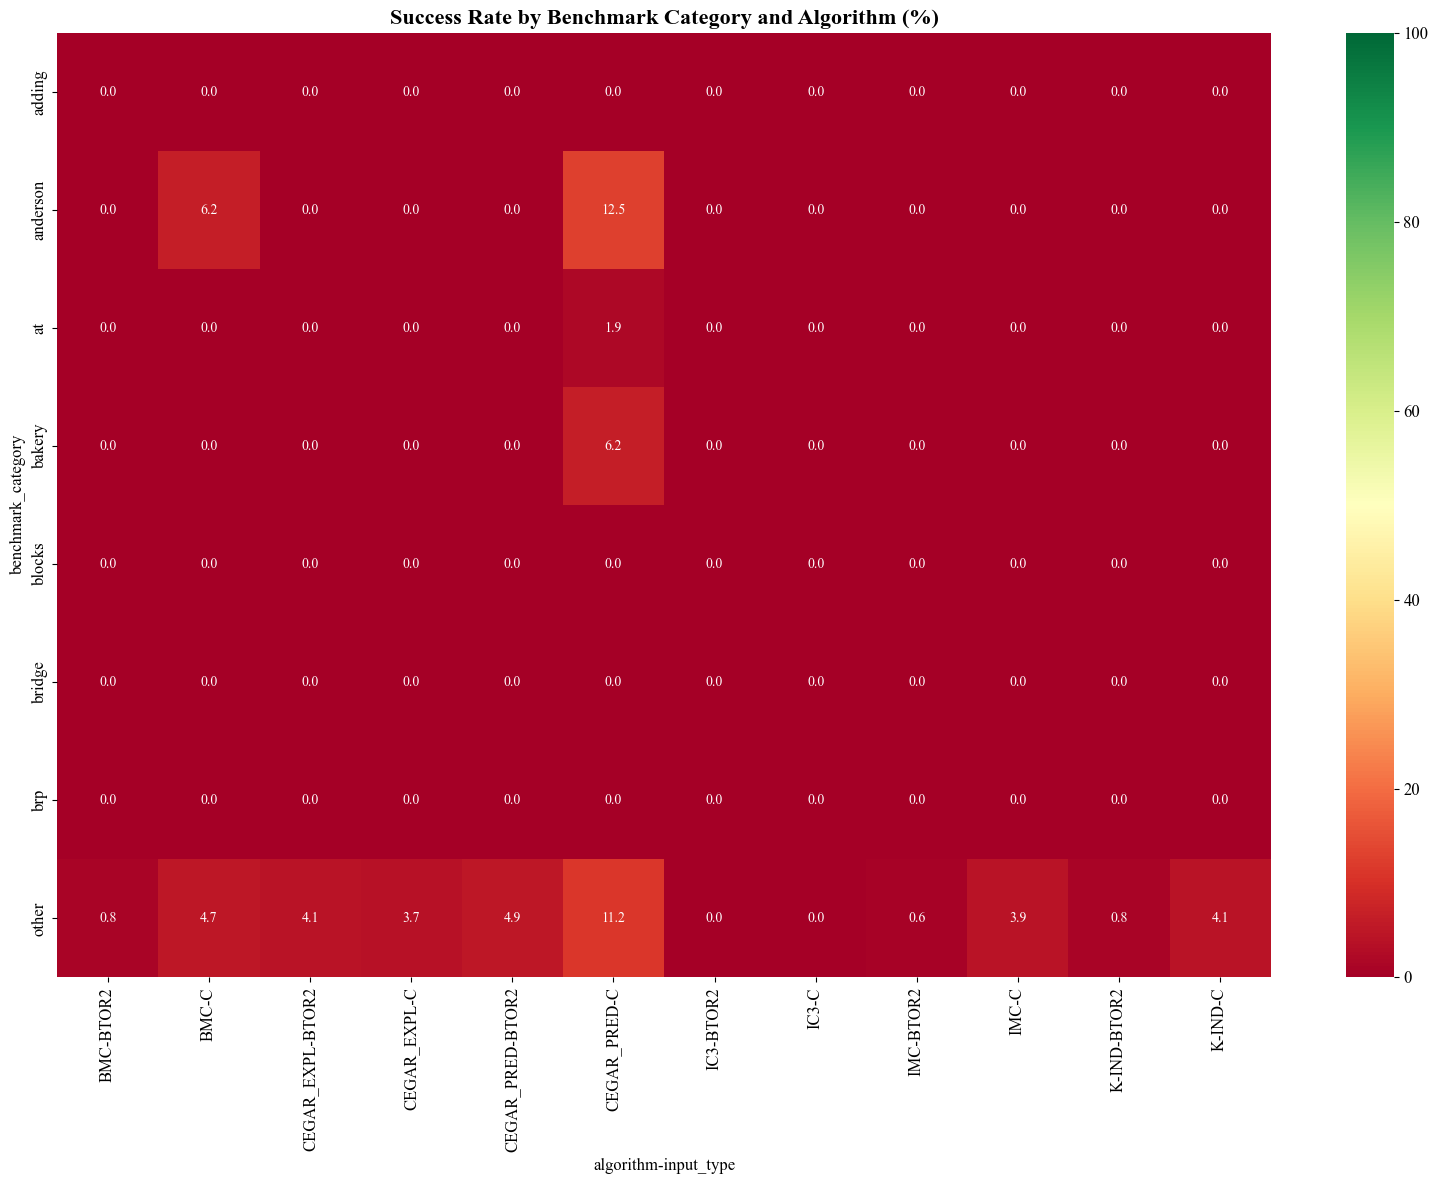

COMPREHENSIVE ALGORITHM PERFORMANCE ANALYSIS

Dataset Overview:
Total benchmark runs: 8316
Unique algorithms: 6
Unique benchmarks: 693

Overall Statistics:
Success rate: 2.4%
Timeout rate: 76.4%
Out-of-memory rate: 8.9%

🏆 ALGORITHM RANKINGS:

BTOR2 Input Type:
  1. CEGAR_EXPL: Success=3.0% (21 runs), CPU Time=26.5s, Score=0.449
  2. CEGAR_PRED: Success=3.6% (25 runs), CPU Time=65.8s, Score=0.369
  3. BMC: Success=0.6% (4 runs), CPU Time=92.5s, Score=0.336
  4. K-IND: Success=0.6% (4 runs), CPU Time=120.7s, Score=0.291
  5. IMC: Success=0.4% (3 runs), CPU Time=189.9s, Score=0.184
  6. IC3: Success=0.0% (0 runs), CPU Time=0.0s, Score=0.000

C Input Type:
  1. CEGAR_EXPL: Success=2.7% (19 runs), CPU Time=95.4s, Score=0.187
  2. CEGAR_PRED: Success=8.8% (61 runs), CPU Time=190.2s, Score=0.070
  3. BMC: Success=3.6% (25 runs), CPU Time=193.8s, Score=0.064
  4. K-IND: Success=3.0% (21 runs), CPU Time=178.0s, Score=0.063
  5. IMC: Success=2.9% (20 runs), CPU Time=201.1s, Score=0.014
  6. IC3

In [3]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

class AlgorithmComparator:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.all_data = pd.DataFrame()
        self.algorithm_results = {}
        
    def detect_algorithm_from_filename(self, filename):
        """Detect algorithm type from filename patterns"""
        filename_lower = filename.lower()
        
        if 'c-bit' in filename_lower:
            input_type = 'C'
        elif 'btor2' in filename_lower:
            input_type = 'BTOR2'
        else:
            input_type = 'UNKNOWN'
            
        # Detect algorithm
        if 'cegar' in filename_lower and 'pred' in filename_lower:
            algorithm = 'CEGAR_PRED'
        elif 'cegar' in filename_lower and 'expl' in filename_lower:
            algorithm = 'CEGAR_EXPL'
        elif 'bounded' in filename_lower:
            algorithm = 'BMC'
        elif 'imc' in filename_lower:
            algorithm = 'IMC'
        elif 'kind' in filename_lower:
            algorithm = 'K-IND'
        elif 'ic3' in filename_lower:
            algorithm = 'IC3'
        else:
            algorithm = 'UNKNOWN'
            
        return algorithm, input_type
    
    def parse_xml_file(self, file_path, algorithm, input_type):
        """Parse XML file and extract benchmark results"""
        try:
            tree = ET.parse(file_path)
            root = tree.getroot()
            
            data = []
            for run in root.findall('run'):
                # Extract benchmark name and properties
                run_name = run.get('name', '')
                properties = run.get('properties', '')
                expected_verdict = run.get('expectedVerdict', '')
                
                # Extract column values
                columns = {}
                for col in run.findall('column'):
                    title = col.get('title')
                    value = col.get('value')
                    columns[title] = value
                
                # Extract benchmark category
                benchmark_category = self.extract_benchmark_category(run_name)
                
                # FIX: Correct success detection - consider both 'true' and 'false' status as successful if they complete
                status = columns.get('status', '')
                # Consider runs with status 'true', 'false', or 'correct' as successful completions
                is_successful = status in ['true', 'false', 'correct', 'false(unreach-call)', ]
                # Consider timeouts and OOM as failures
                is_timeout = status == 'timeout' or 'timeout' in status.lower()
                is_oom = status == 'out of memory' or 'memory' in status.lower()
                
                row_data = {
                    'algorithm': algorithm,
                    'input_type': input_type,
                    'file_name': os.path.basename(file_path),
                    'run_name': run_name,
                    'benchmark_category': benchmark_category,
                    'benchmark_name': self.extract_benchmark_name(run_name),
                    'properties': properties,
                    'expected_verdict': expected_verdict,
                    'status': status,
                    'cputime': self.safe_float(columns.get('cputime', '0').replace('s', '')),
                    'walltime': self.safe_float(columns.get('walltime', '0').replace('s', '')),
                    'memory': self.safe_int(columns.get('memory', '0').replace('B', '')),
                    'host': columns.get('host', ''),
                    'success': 1 if is_successful else 0,
                    'timeout': 1 if is_timeout else 0,
                    'oom': 1 if is_oom else 0
                }
                
                data.append(row_data)
            
            return pd.DataFrame(data)
            
        except Exception as e:
            print(f"Error parsing {file_path}: {e}")
            return pd.DataFrame()
    
    def safe_float(self, value):
        """Safely convert to float"""
        try:
            return float(value)
        except:
            return 0.0
    
    def safe_int(self, value):
        """Safely convert to int"""
        try:
            return int(value)
        except:
            return 0
    
    def extract_benchmark_category(self, run_name):
        """Extract benchmark category from run name"""
        categories = ['adding', 'anderson', 'at', 'bakery', 'blocks', 'bridge', 'brp', 'brp2']
        for category in categories:
            if category in run_name.lower():
                return category
        return 'other'
    
    def extract_benchmark_name(self, run_name):
        """Extract simplified benchmark name"""
        # Extract the core benchmark identifier
        start = run_name.rfind("/") + 1
        end = run_name.rfind(".yml")
        return run_name[start:end] if end != -1 else run_name[start:]
    
    def load_all_data(self):
        """Load and parse all XML files in the folder"""
        xml_files = list(Path(self.folder_path).glob('*.xml'))
        print(f"Found {len(xml_files)} XML files")
        
        all_dfs = []
        
        for xml_file in xml_files:
            algorithm, input_type = self.detect_algorithm_from_filename(xml_file.name)
            print(f"Processing: {xml_file.name} -> {algorithm}/{input_type}")
            
            df = self.parse_xml_file(xml_file, algorithm, input_type)
            if not df.empty:
                all_dfs.append(df)
                print(f"  Loaded {len(df)} runs, {df['success'].sum()} successful")
        
        if all_dfs:
            self.all_data = pd.concat(all_dfs, ignore_index=True)
            print(f"\nLoaded {len(self.all_data)} benchmark results")
            print(f"Algorithms: {self.all_data['algorithm'].unique()}")
            print(f"Input types: {self.all_data['input_type'].unique()}")
            
            # Print success statistics by algorithm and input type
            print("\nSuccess counts by algorithm and input type:")
            success_counts = self.all_data.groupby(['algorithm', 'input_type'])['success'].agg(['sum', 'count'])
            success_counts['success_rate'] = (success_counts['sum'] / success_counts['count'] * 100).round(1)
            print(success_counts)
        else:
            print("No data loaded!")
        
        return self.all_data
    
    def calculate_algorithm_metrics(self):
        """Calculate performance metrics for each algorithm"""
        if self.all_data.empty:
            self.load_all_data()
        
        metrics = []
        
        for (algorithm, input_type), group in self.all_data.groupby(['algorithm', 'input_type']):
            total_benchmarks = len(group)
            successful_count = group['success'].sum()
            success_rate = (successful_count / total_benchmarks) * 100 if total_benchmarks > 0 else 0
            timeout_rate = group['timeout'].mean() * 100
            oom_rate = group['oom'].mean() * 100
            
            # Average performance metrics (only for successful runs)
            successful_runs = group[group['success'] == 1]
            avg_cputime = successful_runs['cputime'].mean() if len(successful_runs) > 0 else 0
            avg_walltime = successful_runs['walltime'].mean() if len(successful_runs) > 0 else 0
            avg_memory = successful_runs['memory'].mean() if len(successful_runs) > 0 else 0
            
            metrics.append({
                'algorithm': algorithm,
                'input_type': input_type,
                'total_benchmarks': total_benchmarks,
                'success_rate': success_rate,
                'timeout_rate': timeout_rate,
                'oom_rate': oom_rate,
                'avg_cputime': avg_cputime,
                'avg_walltime': avg_walltime,
                'avg_memory_gb': avg_memory / 1e9,
                'successful_runs': successful_count
            })
        
        self.algorithm_metrics = pd.DataFrame(metrics)
        return self.algorithm_metrics
    
    def plot_success_rates(self):
        """Plot success rates for all algorithms"""
        if not hasattr(self, 'algorithm_metrics'):
            self.calculate_algorithm_metrics()
        
        # Set Times New Roman font and larger text sizes
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.rcParams['font.size'] = 14
        plt.rcParams['axes.titlesize'] = 16
        plt.rcParams['axes.labelsize'] = 14
        plt.rcParams['xtick.labelsize'] = 12
        plt.rcParams['ytick.labelsize'] = 12
        plt.rcParams['legend.fontsize'] = 12
        
        fig, axes = plt.subplots(2, 2, figsize=(18, 14))
        fig.suptitle('Algorithm Performance Comparison', fontsize=20, fontweight='bold')
        
        # Success rates by algorithm and input type
        pivot_success = self.algorithm_metrics.pivot(index='algorithm', columns='input_type', values='success_rate')
        pivot_success.plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightcoral'])
        axes[0, 0].set_title('Success Rate by Algorithm and Input Type', fontweight='bold', fontsize=16)
        axes[0, 0].set_ylabel('Success Rate (%)', fontsize=14)
        axes[0, 0].set_xlabel('Algorithm', fontsize=14)
        axes[0, 0].tick_params(axis='x', rotation=45)
        axes[0, 0].legend(title='Input Type', title_fontsize=12)
        axes[0, 0].grid(True, alpha=0.3)
        
        # Timeout rates
        pivot_timeout = self.algorithm_metrics.pivot(index='algorithm', columns='input_type', values='timeout_rate')
        pivot_timeout.plot(kind='bar', ax=axes[0, 1], color=['skyblue', 'lightcoral'])
        axes[0, 1].set_title('Timeout Rate by Algorithm and Input Type', fontweight='bold', fontsize=16)
        axes[0, 1].set_ylabel('Timeout Rate (%)', fontsize=14)
        axes[0, 1].set_xlabel('Algorithm', fontsize=14)
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].legend(title='Input Type', title_fontsize=12)
        axes[0, 1].grid(True, alpha=0.3)
        
        # Average CPU time (successful runs only)
        successful_metrics = self.algorithm_metrics[self.algorithm_metrics['successful_runs'] > 0]
        if not successful_metrics.empty:
            pivot_cputime = successful_metrics.pivot(index='algorithm', columns='input_type', values='avg_cputime')
            pivot_cputime.plot(kind='bar', ax=axes[1, 0], color=['lightgreen', 'orange'])
            axes[1, 0].set_title('Average CPU Time (Successful Runs)', fontweight='bold', fontsize=16)
            axes[1, 0].set_ylabel('CPU Time (s)', fontsize=14)
            axes[1, 0].set_xlabel('Algorithm', fontsize=14)
            axes[1, 0].tick_params(axis='x', rotation=45)
            axes[1, 0].legend(title='Input Type', title_fontsize=12)
            axes[1, 0].grid(True, alpha=0.3)
        
        # Average memory usage
        if not successful_metrics.empty:
            pivot_memory = successful_metrics.pivot(index='algorithm', columns='input_type', values='avg_memory_gb')
            pivot_memory.plot(kind='bar', ax=axes[1, 1], color=['lightgreen', 'orange'])
            axes[1, 1].set_title('Average Memory Usage (Successful Runs)', fontweight='bold', fontsize=16)
            axes[1, 1].set_ylabel('Memory (GB)', fontsize=14)
            axes[1, 1].set_xlabel('Algorithm', fontsize=14)
            axes[1, 1].tick_params(axis='x', rotation=45)
            axes[1, 1].legend(title='Input Type', title_fontsize=12)
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('algorithm_performance_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Reset font settings to default
        plt.rcParams.update(plt.rcParamsDefault)
    
    def plot_benchmark_category_analysis(self):
        """Analyze performance by benchmark category"""
        if self.all_data.empty:
            self.load_all_data()
        
        # Set Times New Roman font for this plot as well
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.rcParams['font.size'] = 12
        
        # Calculate success rates by category and algorithm
        category_stats = self.all_data.groupby(['benchmark_category', 'algorithm', 'input_type']).agg({
            'success': 'mean',
            'cputime': 'mean',
            'memory': 'mean',
            'run_name': 'count'
        }).reset_index()
        
        category_stats['success_rate'] = category_stats['success'] * 100
        
        # Pivot for heatmap
        pivot_success = category_stats.pivot_table(
            index='benchmark_category', 
            columns=['algorithm', 'input_type'], 
            values='success_rate', 
            aggfunc='mean'
        ).fillna(0)
        
        plt.figure(figsize=(16, 12))
        sns.heatmap(pivot_success, annot=True, fmt='.1f', cmap='RdYlGn', 
                   center=50, vmin=0, vmax=100, annot_kws={"size": 10})
        plt.title('Success Rate by Benchmark Category and Algorithm (%)', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('category_success_heatmap.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Reset font settings to default
        plt.rcParams.update(plt.rcParamsDefault)
        
        return category_stats
    
    def rank_algorithms(self):
        """Rank algorithms based on multiple criteria"""
        if not hasattr(self, 'algorithm_metrics'):
            self.calculate_algorithm_metrics()
        
        # Create scoring system
        ranking_data = self.algorithm_metrics.copy()
        
        # Normalize metrics (higher is better for success, lower is better for time/memory)
        ranking_data['score_success'] = ranking_data['success_rate'] / 100
        
        # Only calculate time/memory scores for algorithms with successful runs
        max_cputime = ranking_data['avg_cputime'].max()
        max_memory = ranking_data['avg_memory_gb'].max()
        
        ranking_data['score_time'] = ranking_data.apply(
            lambda x: 1 - (x['avg_cputime'] / max_cputime) if max_cputime > 0 and x['successful_runs'] > 0 else 0, 
            axis=1
        )
        ranking_data['score_memory'] = ranking_data.apply(
            lambda x: 1 - (x['avg_memory_gb'] / max_memory) if max_memory > 0 and x['successful_runs'] > 0 else 0, 
            axis=1
        )
        
        # Combined score (weighted)
        ranking_data['combined_score'] = (
            0.5 * ranking_data['score_success'] +  # Success rate is most important
            0.3 * ranking_data['score_time'] +     # Time performance
            0.2 * ranking_data['score_memory']     # Memory efficiency
        )
        
        # Rank within each input type
        ranking_data['rank'] = ranking_data.groupby('input_type')['combined_score'].rank(ascending=False)
        
        # Sort by input type and rank
        ranking_data = ranking_data.sort_values(['input_type', 'rank'])
        
        return ranking_data[['algorithm', 'input_type', 'success_rate', 'avg_cputime', 
                           'avg_memory_gb', 'combined_score', 'rank', 'successful_runs']]
    
    def generate_comprehensive_report(self):
        """Generate a comprehensive performance report"""
        print("="*80)
        print("COMPREHENSIVE ALGORITHM PERFORMANCE ANALYSIS")
        print("="*80)
        
        if self.all_data.empty:
            self.load_all_data()
        
        # Basic statistics
        total_benchmarks = len(self.all_data)
        unique_algorithms = self.all_data['algorithm'].nunique()
        unique_benchmarks = self.all_data['benchmark_name'].nunique()
        
        print(f"\nDataset Overview:")
        print(f"Total benchmark runs: {total_benchmarks}")
        print(f"Unique algorithms: {unique_algorithms}")
        print(f"Unique benchmarks: {unique_benchmarks}")
        
        # Overall success rates
        overall_success = self.all_data['success'].mean() * 100
        overall_timeout = self.all_data['timeout'].mean() * 100
        overall_oom = self.all_data['oom'].mean() * 100
        
        print(f"\nOverall Statistics:")
        print(f"Success rate: {overall_success:.1f}%")
        print(f"Timeout rate: {overall_timeout:.1f}%")
        print(f"Out-of-memory rate: {overall_oom:.1f}%")
        
        # Algorithm rankings
        rankings = self.rank_algorithms()
        
        print(f"\n🏆 ALGORITHM RANKINGS:")
        for input_type in ['BTOR2', 'C']:
            print(f"\n{input_type} Input Type:")
            input_rankings = rankings[rankings['input_type'] == input_type]
            for _, row in input_rankings.iterrows():
                print(f"  {row['rank']:.0f}. {row['algorithm']}: "
                      f"Success={row['success_rate']:.1f}% ({row['successful_runs']} runs), "
                      f"CPU Time={row['avg_cputime']:.1f}s, "
                      f"Score={row['combined_score']:.3f}")
        
        # Best overall algorithm
        if not rankings.empty:
            best_overall = rankings.loc[rankings['combined_score'].idxmax()]
            print(f"\n🎯 BEST OVERALL ALGORITHM:")
            print(f"  {best_overall['algorithm']} ({best_overall['input_type']})")
            print(f"  Success Rate: {best_overall['success_rate']:.1f}%")
            print(f"  Successful Runs: {best_overall['successful_runs']}")
            print(f"  Average CPU Time: {best_overall['avg_cputime']:.1f}s")
            print(f"  Performance Score: {best_overall['combined_score']:.3f}")
        
        # Save detailed results
        self.all_data.to_csv('all_benchmark_results.csv', index=False)
        rankings.to_csv('algorithm_rankings.csv', index=False)
        
        print(f"\n📊 Detailed results saved to:")
        print(f"  - all_benchmark_results.csv")
        print(f"  - algorithm_rankings.csv")
        print(f"  - algorithm_performance_comparison.png")
        print(f"  - category_success_heatmap.png")
    
    def run_complete_analysis(self):
        """Run complete analysis pipeline"""
        print("Starting comprehensive algorithm analysis...")
        
        # Load data
        self.load_all_data()
        
        # Calculate metrics
        self.calculate_algorithm_metrics()
        
        # Generate visualizations
        self.plot_success_rates()
        self.plot_benchmark_category_analysis()
        
        # Generate report
        self.generate_comprehensive_report()
        
        print("\n✅ Analysis complete!")

# Example usage
def main():
    # Specify the folder containing all XML files
    folder_path = "result_xmls"  # Current directory, change as needed
    
    # Initialize comparator
    comparator = AlgorithmComparator(folder_path)
    
    # Run complete analysis
    comparator.run_complete_analysis()

if __name__ == "__main__":
    main()